In [109]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import cartopy.feature as cfea

In [112]:
def get_coordinate(city_index):
    # open city information text
    city_path = '/home/kajiyama/H08/H08_20230612/map/dat/cty_lst_/cityrange_list_temp.txt'
    with open(city_path, "r") as file:
        all_lines = file.readlines()
    # get city
    line = all_lines[city_index - 1]
    line = line.strip()
    parts = line.split()
    
    city_num = parts[0].zfill(3)
    city = parts[5].replace("\"", "").replace("?", "").replace("/", "")
    
    lonmin = float(parts[6])
    lonmax = float(parts[7])
    latmin = float(parts[8])
    latmax = float(parts[9])

    # Dimension of the data
    a = 2160
    b = 4320

    ### Define the latitudes and longitudes
    # West from UK is negative 0 <= lon <= -180
    # East from UK is positive 0 <= lon <= 180
    # small value to larger value (34-36, 138-140)
    lat = np.linspace(-90, 90, a+1)
    lon = np.linspace(-180, 180, b+1)

    # calculate the indices correspondignt to the desired lat and lon
    lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
    lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])

    ### adjust to 0.25 grid
    # lat
    if lat_start%3 == 0:
        lat_start = lat_start
    elif lat_start%3 == 1:
        lat_start -= 1
    elif lat_start%3 == 2:
        lat_start += 1

    # lon
    if lon_start%3 == 0:
        lon_start = lon_start
    elif lon_start%3 == 1:
        lon_start -= 1
    elif lon_start%3 == 2:
        lon_start += 1

    # 24 grid x 24 grid
    lat_end = lat_start + 24
    lon_end = lon_start + 24

    # convert real lonlat to h08 lonlat
    latmin_gl5 = lat[lat_start]
    latmax_gl5 = lat[lat_end]
    lonmin_gl5 = lon[lon_start]
    lonmax_gl5 = lon[lon_end]
    
    return lat_start, lat_end, lon_start, lon_end, latmin_gl5, latmax_gl5, lonmin_gl5, lonmax_gl5

In [113]:
#-----------------------------------------------
# Draw city mask
#-----------------------------------------------

def draw_mask(mask_temp, pop_temp, city_index, loop_num, maximum_value):
    # get city lonlat
    lat_start, lat_end, lon_start, lon_end, latmin_gl5, latmax_gl5, lonmin_gl5, lonmax_gl5 = get_coordinate(city_index)

    # crop
    mask_flipped = np.flipud(mask_temp)
    mask_cropped = mask_flipped[lat_start:lat_end, lon_start:lon_end]
    mask_cropped_flipped = np.flipud(mask_cropped)
    
    # pop
    pop_flipped = np.flipud(pop_temp)
    pop_cropped = pop_flipped[lat_start:lat_end, lon_start:lon_end]
    pop_cropped_flipped = np.flipud(pop_cropped)

    # extent
    projection = ccrs.PlateCarree()
    img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

    # figure
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    im = ax.imshow(pop_cropped_flipped,
                   origin='upper',
                   extent=img_extent,
                   transform=projection,
                   cmap='gist_heat_r',
                   #norm=colors.LogNorm(vmin=1, vmax=1e6),
                  )
                                       
    seethrough = np.ma.masked_where(mask_cropped_flipped == 0, mask_cropped_flipped)
    seethrough[-1, -1] = 0
    im2 = ax.imshow(seethrough,
                   origin='upper',
                   extent=img_extent,
                   transform=projection,
                   cmap='gray_r'
                   )
    
    # save figure
    gif_path = f'./gifs/{loop_num:08}.jpg'
    plt.title(f"maximum population density {maximum_value} / km2")
    plt.savefig(gif_path)
    plt.show()

In [117]:
def explore_citymask(index):

    #-----------------------------------------------
    # Initialization
    #-----------------------------------------------

    # map data
    MAP='CAMA'

    # explore grid radius
    radius_max = 12

    # search radius (1grid in 0.5degree)
    circle = 3

    # lower limitation of population density
    # if lowlim>=1e-9, tokyo mask looks like doi & kato's result
    lowlim = 1

    # initial grid threshold
    threshold = 100

    # shape
    lat_shape = 2160
    lon_shape = 4320

    # date type
    dtype= 'float32'

    # h08 directory
    h08dir = '/home/kajiyama/H08/H08_20230612'

    # initialize variables
    best_coverage = float('inf')
    best_mask = None
    best_masked_pop = None

    #-----------------------------------------------
    # load true data (UN city list) unit=[1000person]
    #-----------------------------------------------

    # true population and city name
    un_pop_list = []
    name_list = []

    # load data
    inf_path = h08dir + '/map/dat/cty_lst_/city_list03.txt'
    for l in open(inf_path).readlines():
        data = l[:-1].split('	')
        un_pop_list.append(int(data[4]))
        name_list.append(data[5])

    # get true UN city population
    un_pop = un_pop_list[index-1]*1000

    # get city name
    city_name = name_list[index-1]

    #-----------------------------------------------
    #  Get area(m2)
    #-----------------------------------------------

    area_path = f'{h08dir}/map/dat/lnd_ara_/lndara.{MAP}.gl5'
    area = np.fromfile(area_path, dtype=dtype).reshape(lat_shape, lon_shape)

    #-----------------------------------------------
    # load gwp population data
    #-----------------------------------------------

    # population data(GWP4 2000)
    pop_path = f'{h08dir}/map/dat/pop_tot_/C05_a___20000000.gl5'
    gwp_pop = np.fromfile(pop_path, dtype=dtype).reshape(lat_shape, lon_shape)

    # population density (person/km2)
    gwp_pop_density = (gwp_pop / (area / 10**6))

    #-----------------------------------------------
    # load city_center coordinate
    #-----------------------------------------------

    center_path = f'{h08dir}/map/dat/cty_cnt_/city_{index:08d}.gl5'
    location = np.fromfile(center_path, dtype=dtype).reshape(lat_shape,lon_shape)
    x = np.where(location==1)[0]
    y = np.where(location==1)[1]
    x = x[0]
    y = y[0]

    #-----------------------------------------------
    # check city center
    #-----------------------------------------------

    # original city center
    org_cnt = gwp_pop[x, y]

    # number of replacement
    replaced_num = 0

    # if there is larger grid, center grid is replaced
    for a in range(x-circle, x+circle+1):
        for b in range(y-circle, y+circle+1):
            candidate = gwp_pop[a, b]
            if candidate >= org_cnt:
                org_cnt = candidate
                x = a
                y = b
                replaced_num += 1

    #-----------------------------------------------
    #  Initialization of mask array
    #-----------------------------------------------

    # mask array for saving
    mask = np.zeros((lat_shape,lon_shape), dtype=dtype)
    mask[x, y] = 1

    #-----------------------------------------------
    #  Explore start
    #-----------------------------------------------

    # stop flag
    new_mask_added = True
    coverage_flag = True

    # city center
    best_mask = mask
    grid_num = np.sum(best_mask)
    best_masked_pop = np.sum(gwp_pop*mask)
    best_coverage = float(best_masked_pop / un_pop)

    # initial grid threshold
    if gwp_pop_density[x, y] <= threshold:
        print("/// stop ///")
        print("/// stop ///")
        print("/// stop ///")
        print("/// stop ///")
        print(f"initial density {gwp_pop_density[x, y]} less than threshold {threshold}")
        print("/// stop ///")
        print("/// stop ///")
        print("/// stop ///")
        print("/// stop ///")
        new_maske_added = False
        coverage_flag = False

    # loop start
    loop_num = 0
    while new_mask_added:

        ### make search list
        search_lst = []
        new_mask_added = False
        for a in range(max(0, x - radius_max), min(x + radius_max + 1, lat_shape)):
            for b in range(max(0, y - radius_max), min(y + radius_max + 1, lon_shape)):
                if mask[a, b] == 1:
                    # explore surrounded 8 grids
                    for dx, dy in [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, 1)]:
                        i, j = a + dx, b + dy
                        # not explored yet
                        if mask[i, j] == 0:
                            # within grid range
                            if 0 <= i < lat_shape and 0<= j < lon_shape:
                                search_lst.append([gwp_pop_density[i, j], i, j])

        ### add searched grid
        # empty check
        if not search_lst:
            new_mask_added = False
            coverage_flag = False
        # get largest grid
        else:
            
            sorted_search = sorted(search_lst, key=lambda x: x[0], reverse=True)
            largest = sorted_search[0]
            # if largest grid value is too small, stop exploring
            if gwp_pop_density[largest[1], largest[2]] <= lowlim:
                print("/// stop ///")
                print("/// stop ///")
                print("/// stop ///")
                print("/// stop ///")
                print(f"largest density {gwp_pop_density[largest[1], largest[2]]} smaller than lowlim {lowlim}")
                print([gwp_pop_density[t[1], t[2]]for t in sorted_search])
                print("/// stop ///")
                print("/// stop ///")
                print("/// stop ///")
                print("/// stop ///")
                new_mask_added = False
                coverage_flag = False
                
        # stop flag
        if coverage_flag is True:
                new_mask_added = True

                # evaluate coverage
                gwp_masked_pop = np.sum(mask * gwp_pop)
                coverage = float(gwp_masked_pop / un_pop)

                # stop exploring
                if coverage >= 1.0:
                    new_mask_added = False
                    coverage_flag = False

                # judge
                judge_value = abs(1 - coverage)
                best_value = abs(1 - best_coverage)
                
                # update
                if judge_value < best_value:
                    best_coverage = coverage
                    best_mask = mask
                    best_masked_pop = gwp_masked_pop
                    grid_num = np.sum(best_mask)
        
        # search_lst is colored
        for cand in search_lst:
            mask[cand[1], cand[2]] = 0.1
        # for drawing
        mask[largest[1], largest[2]] = 0.3
        
        # draw
        # cand = 0.3
        # largest = 0.6
        # citymask = 1
        maximum_value = np.round(gwp_pop_density[largest[1], largest[2]])
        draw_mask(best_mask, gwp_pop_density, index, loop_num, maximum_value)
        # reset
        mask[mask == 0.1] = 0
        mask[mask == 0.3] = 1
        # loop count
        loop_num += 1

    #-----------------------------------------------
    # Output result
    #-----------------------------------------------

    print('#########################################')
    print(
          f"explored_pop {best_masked_pop}\n" \
          f"true_pop {un_pop}\n" \
          f"coverage {best_coverage}\n" \
          f"city_mask {grid_num}\n" \
          f"{city_name}"
          )
    print('#########################################')

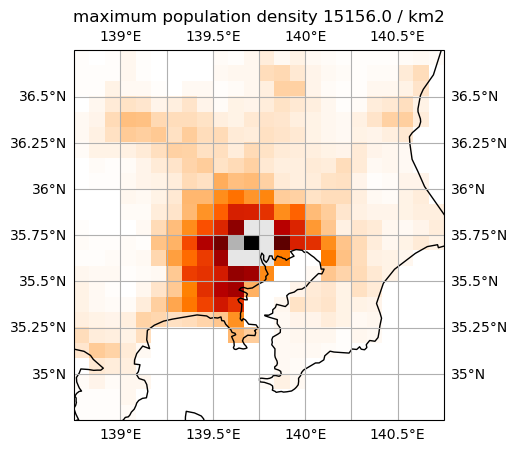

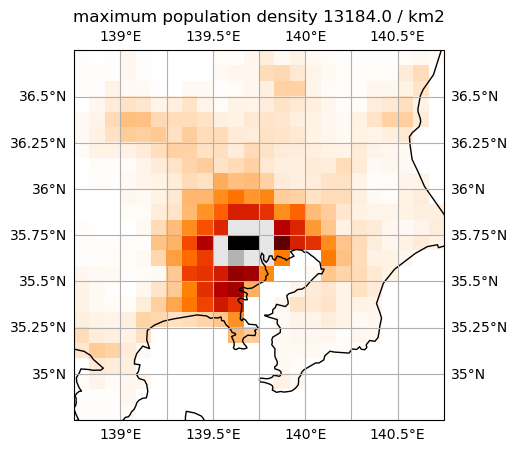

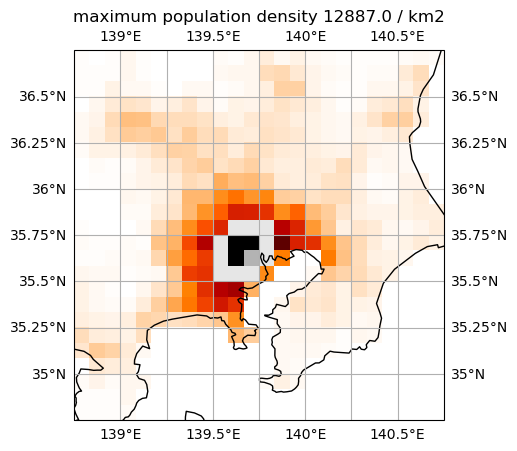

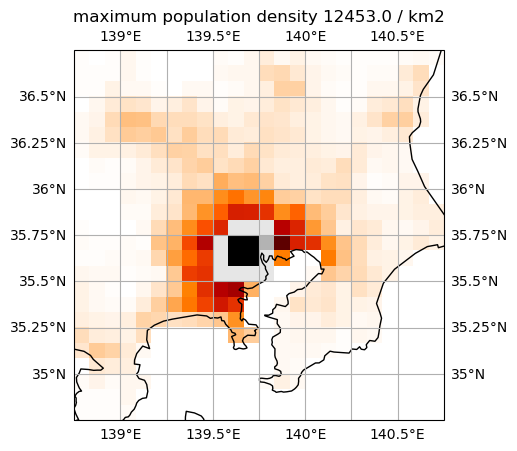

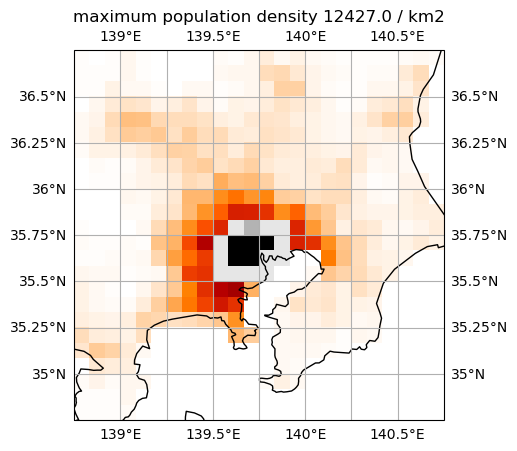

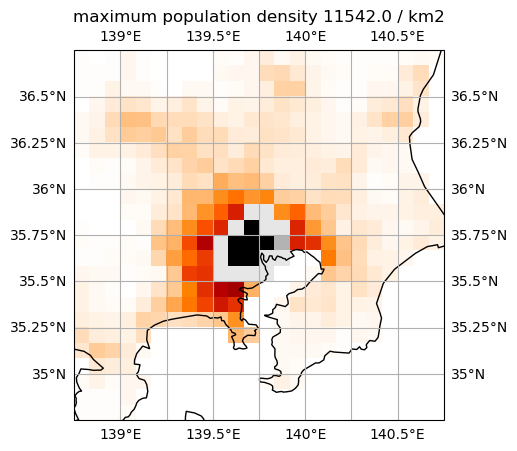

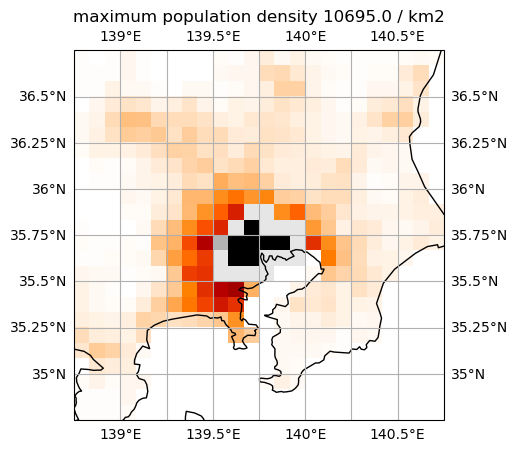

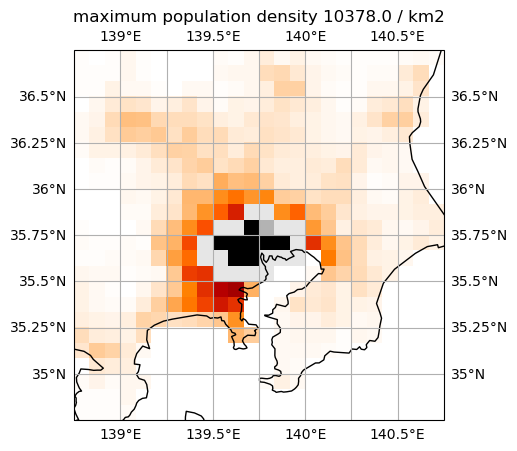

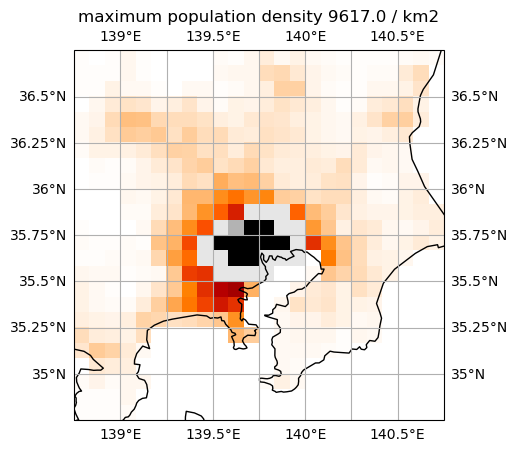

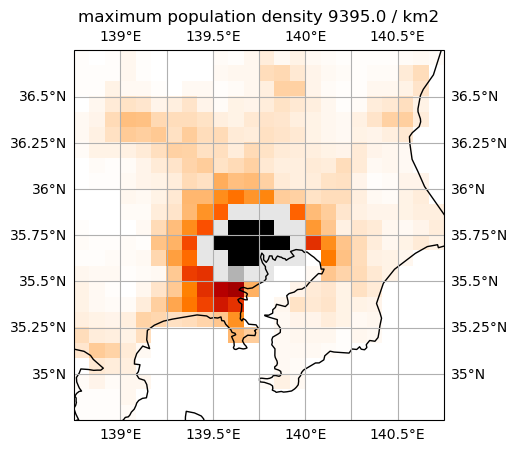

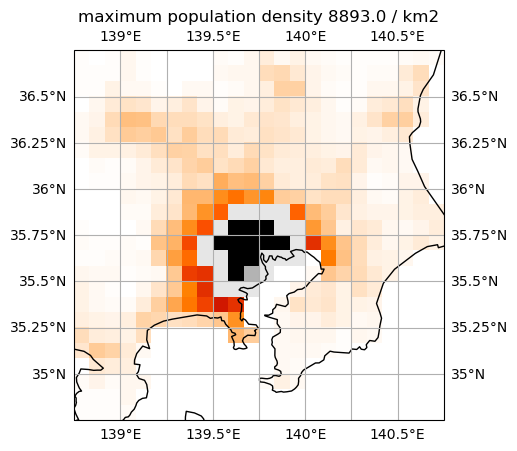

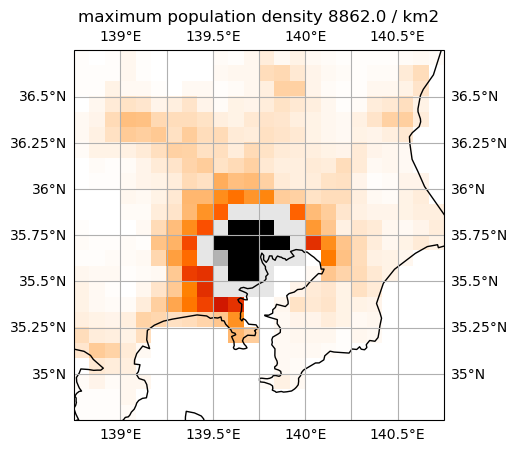

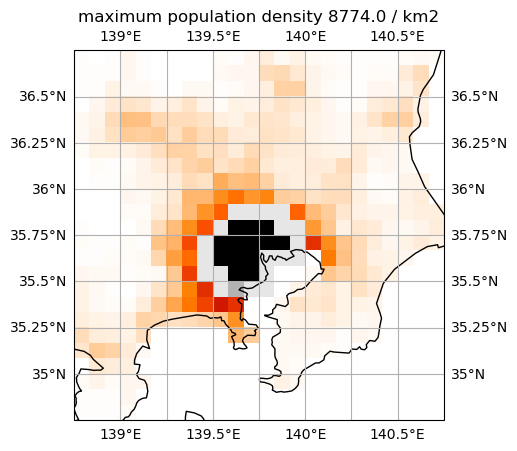

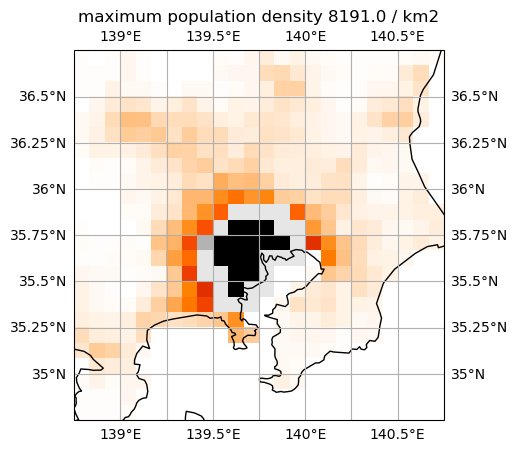

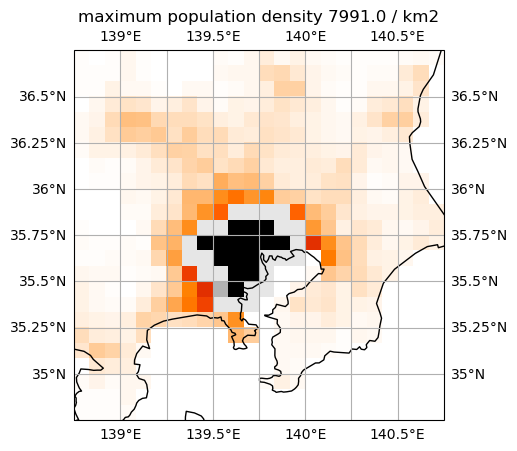

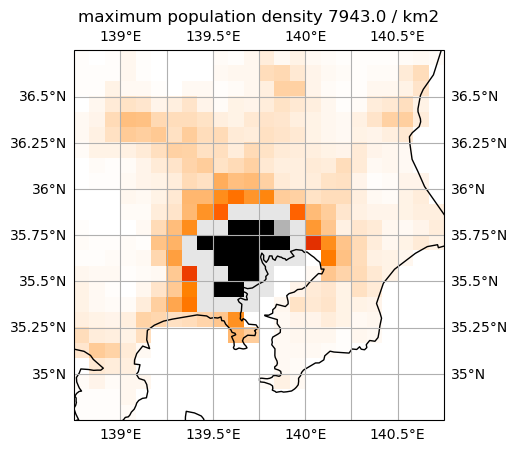

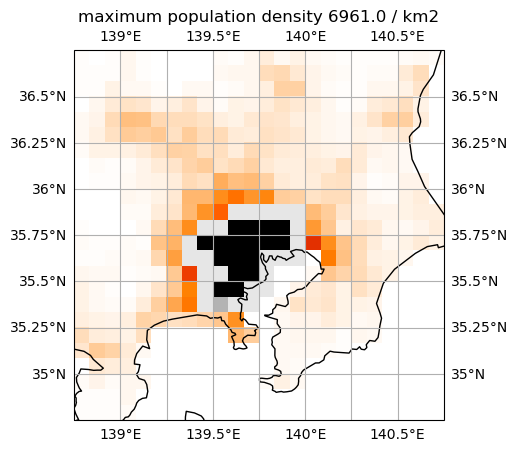

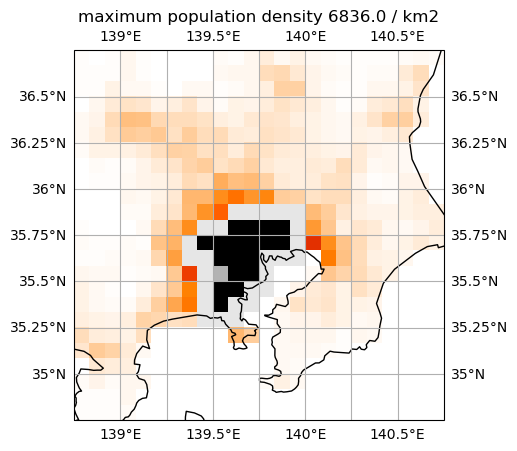

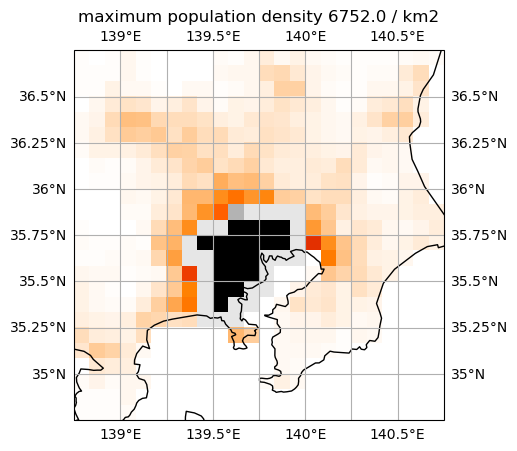

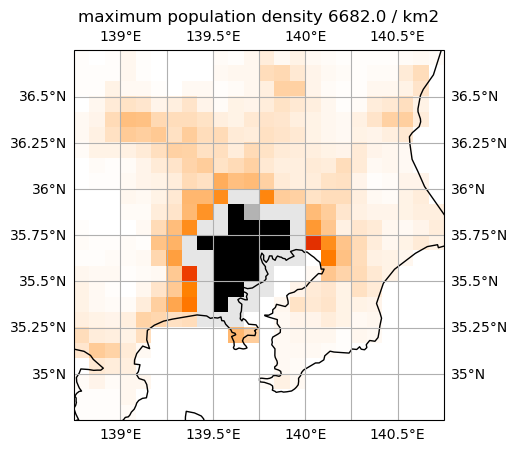

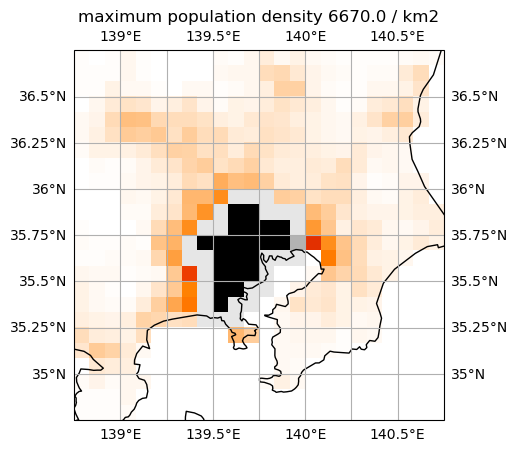

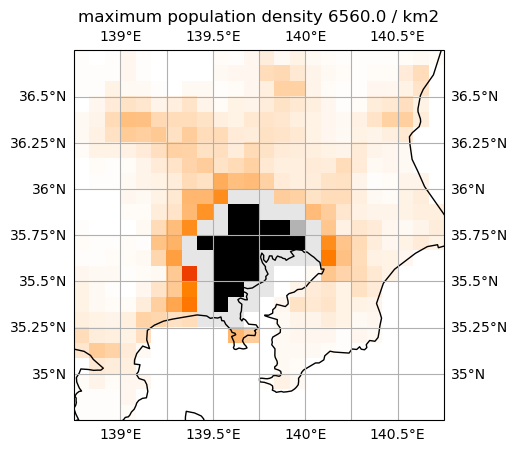

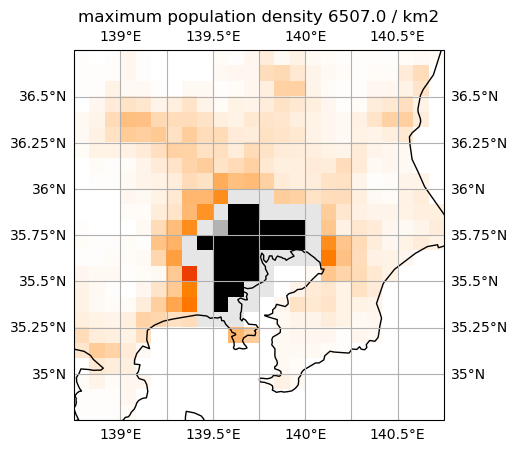

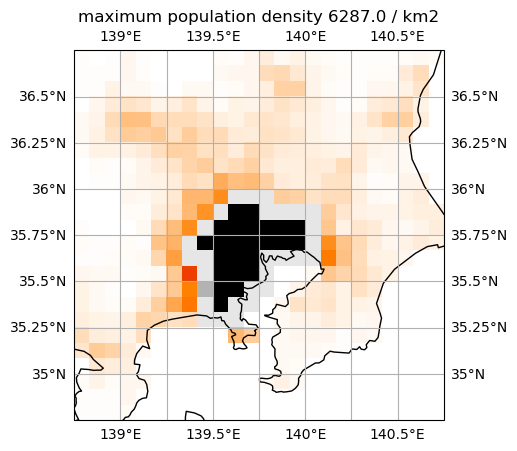

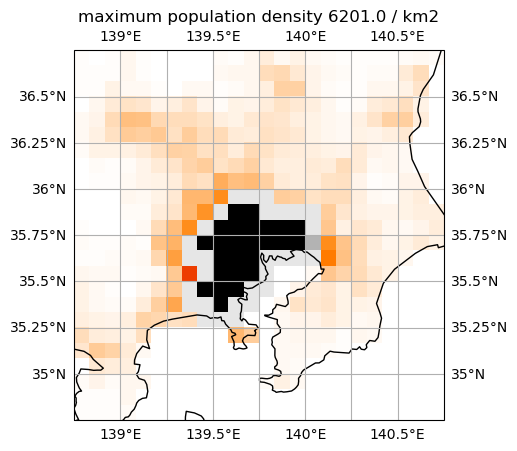

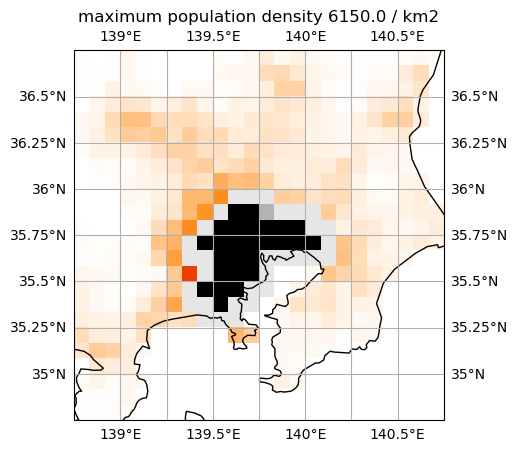

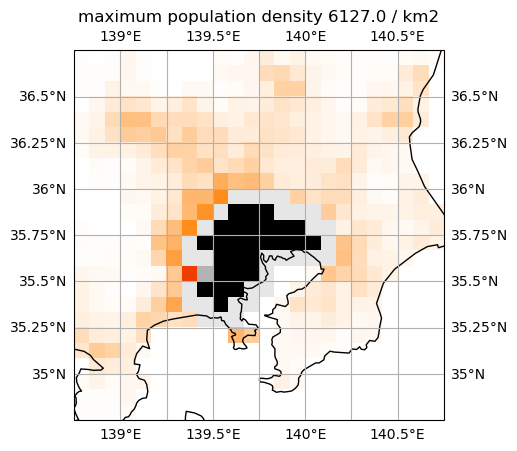

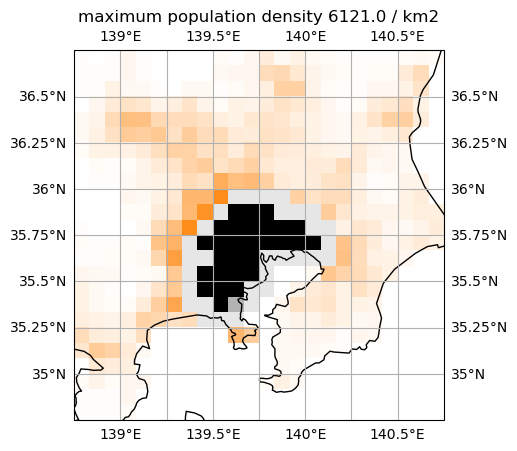

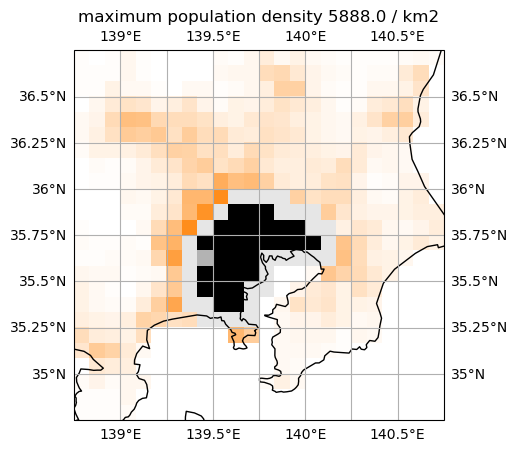

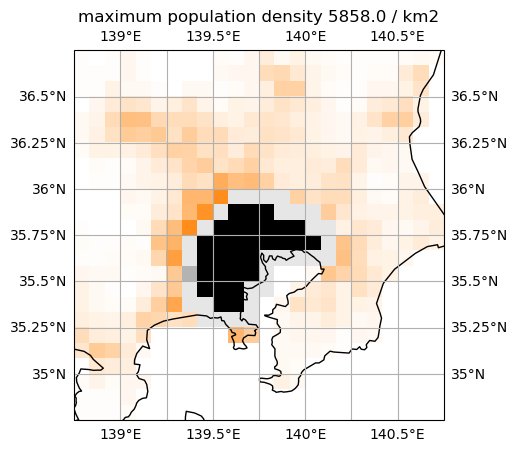

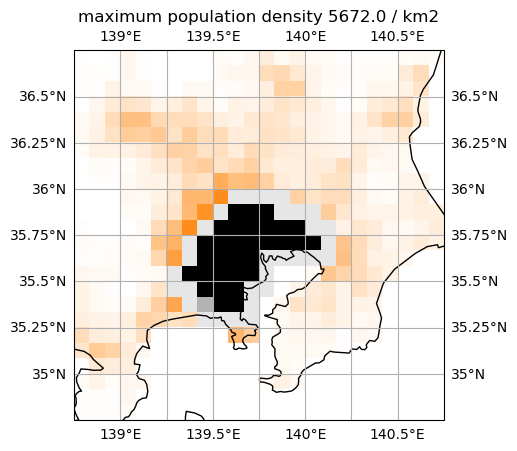

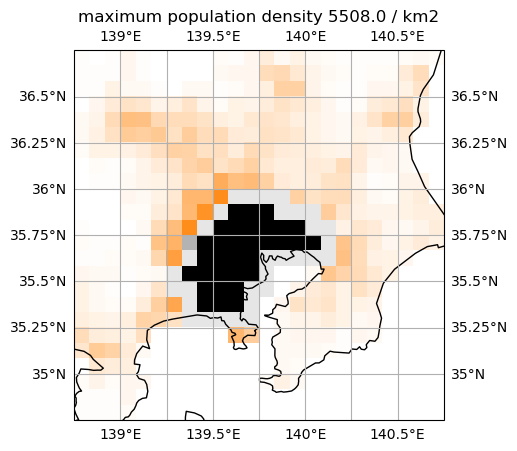

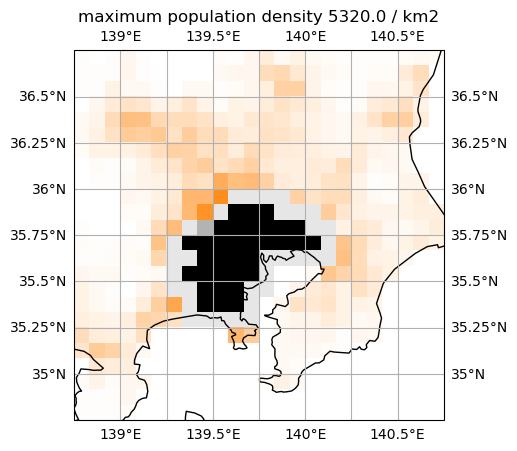

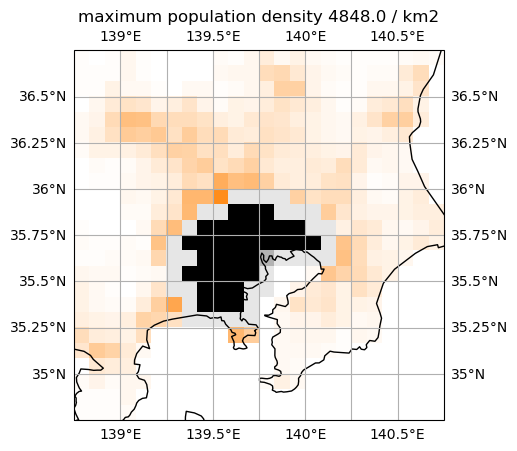

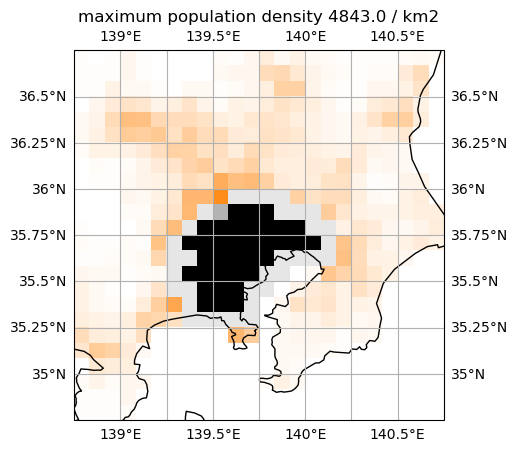

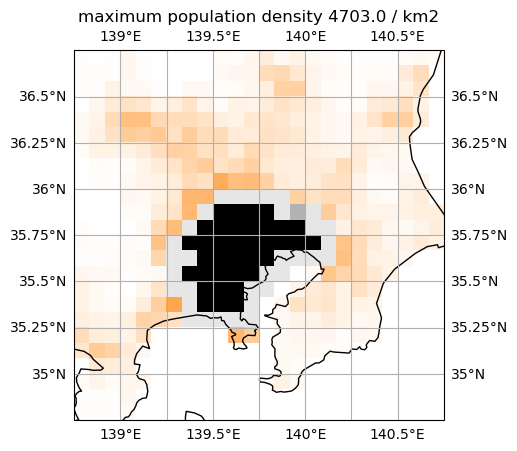

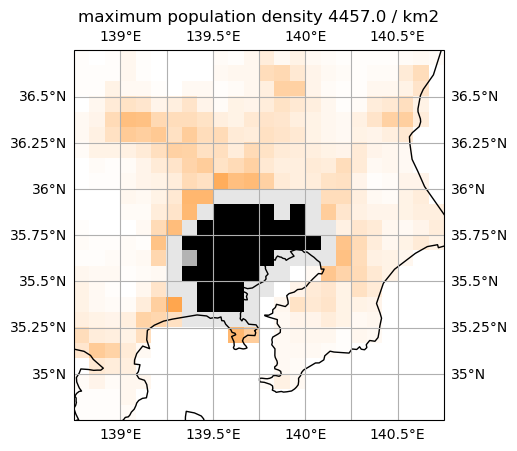

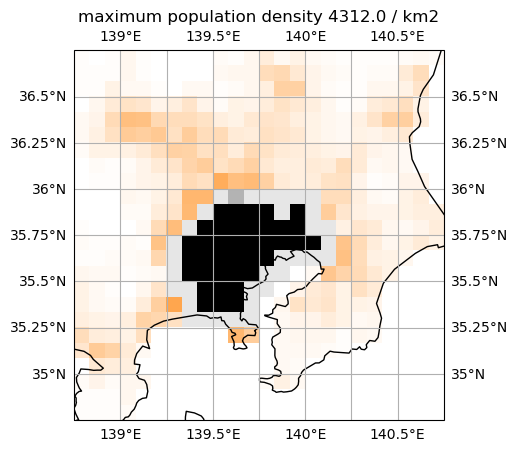

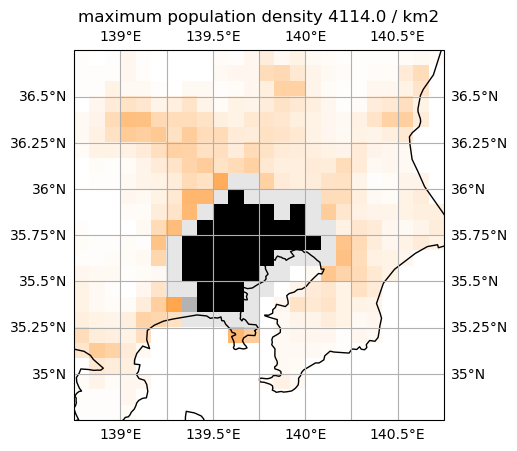

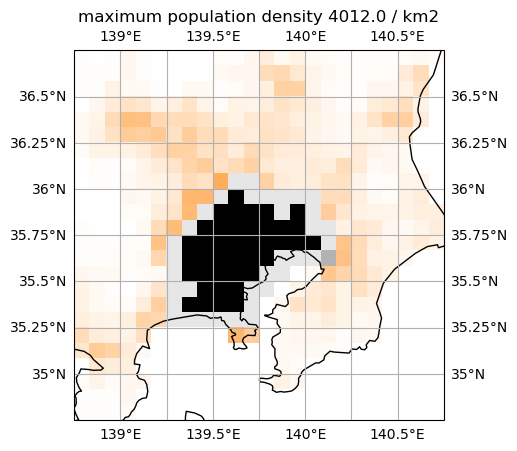

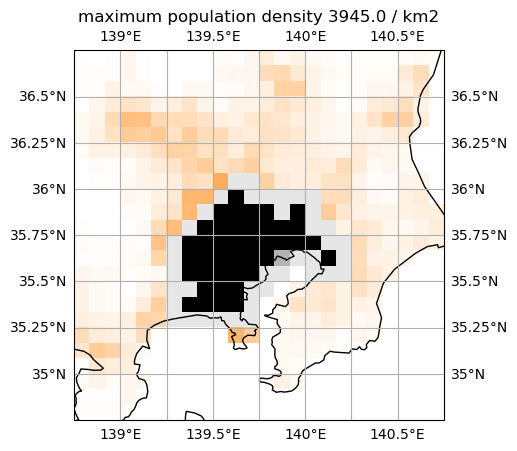

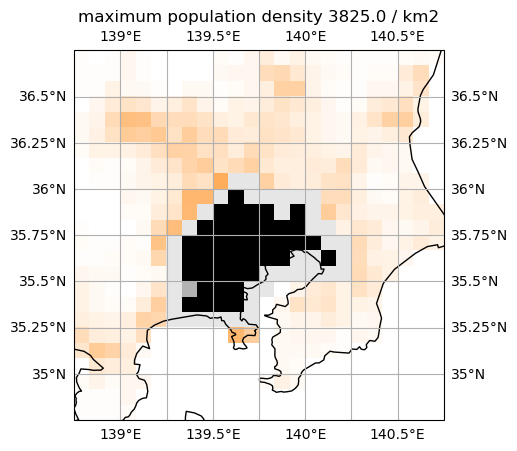

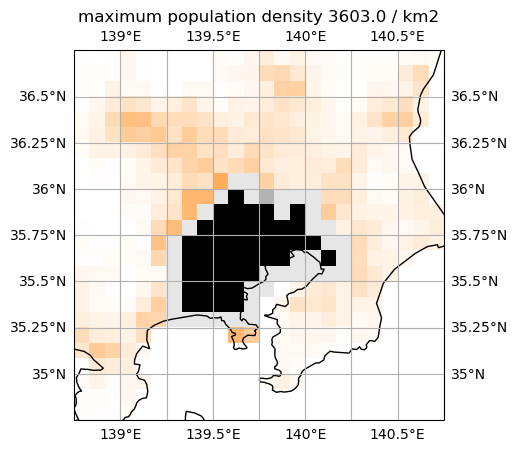

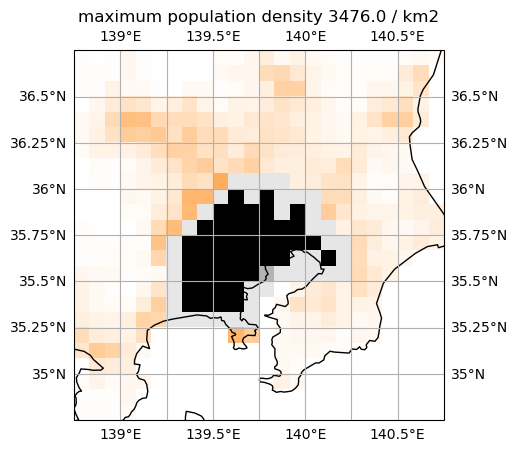

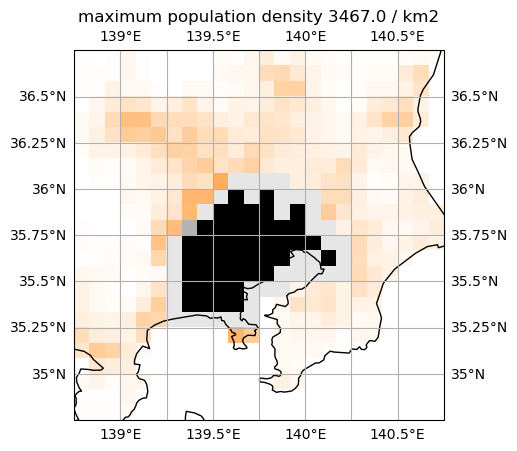

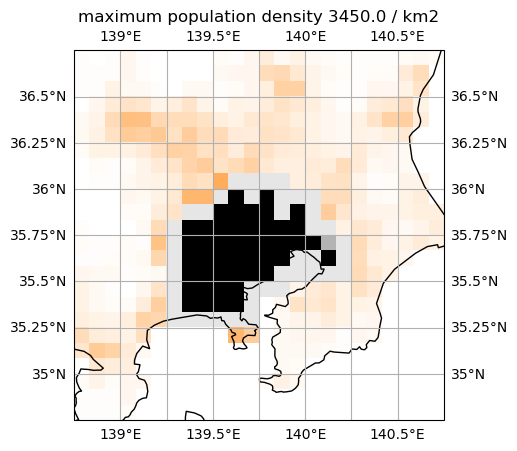

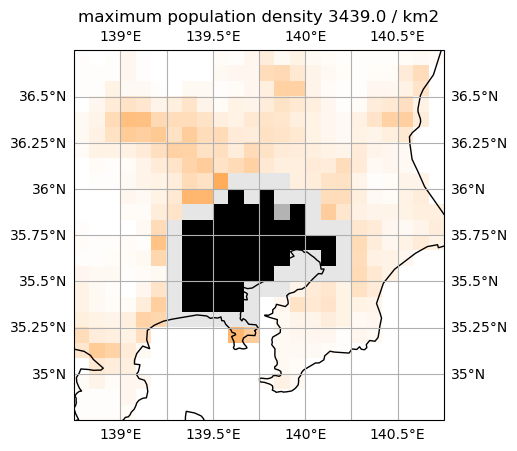

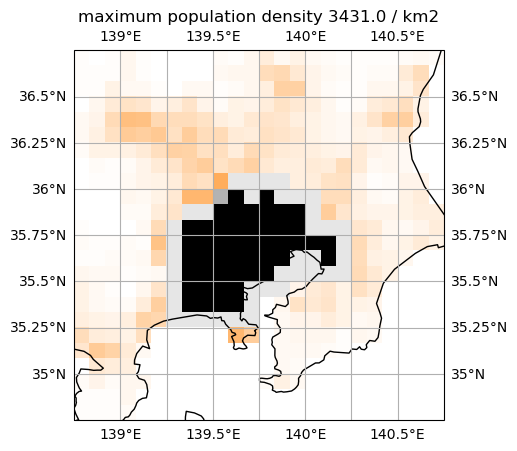

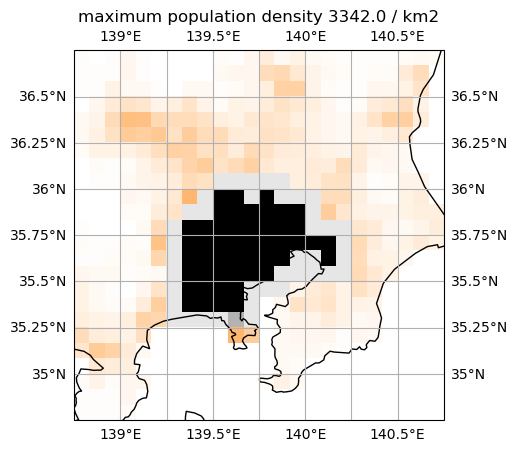

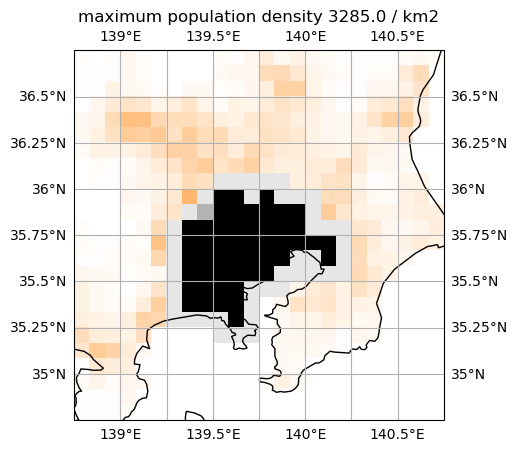

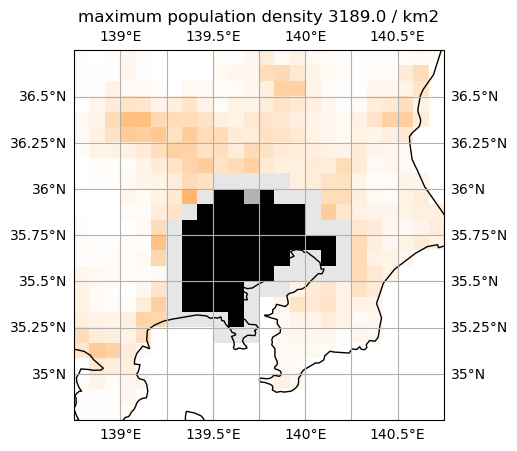

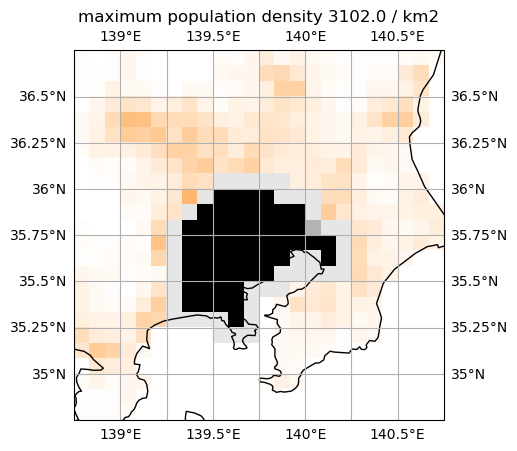

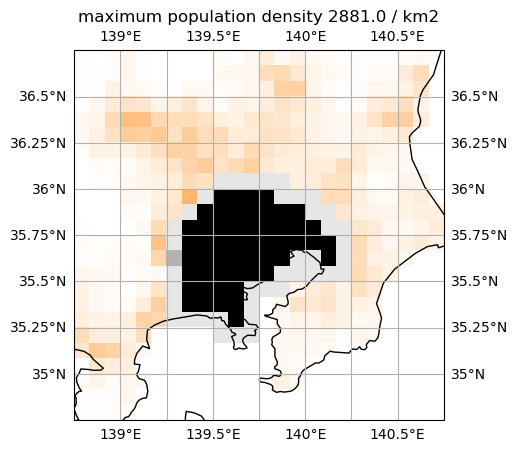

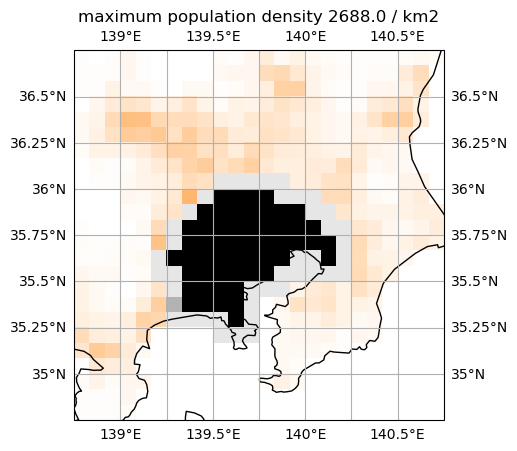

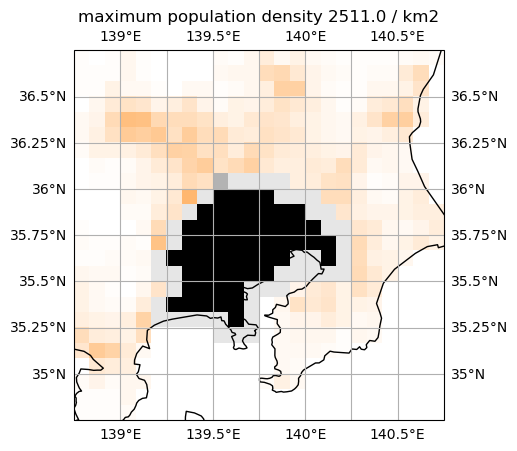

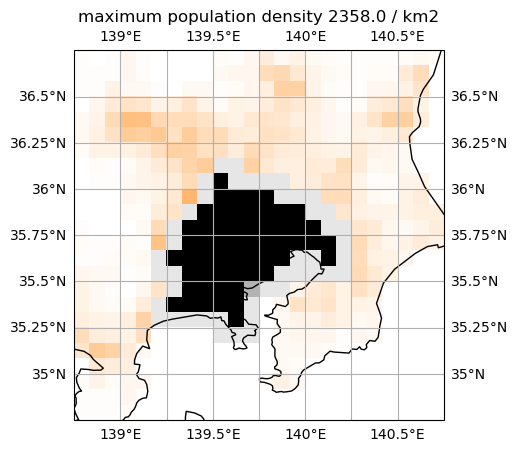

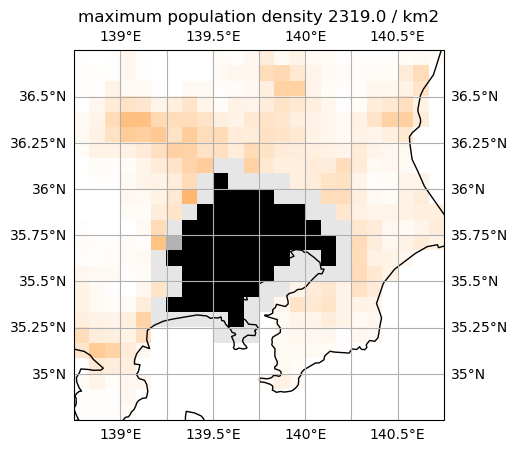

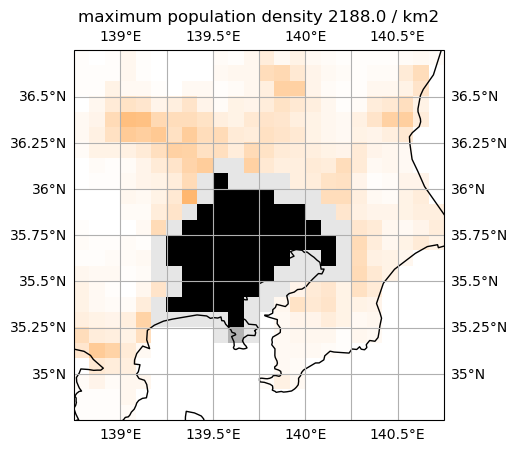

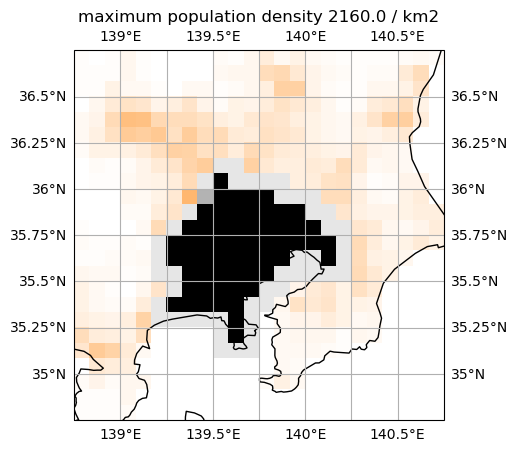

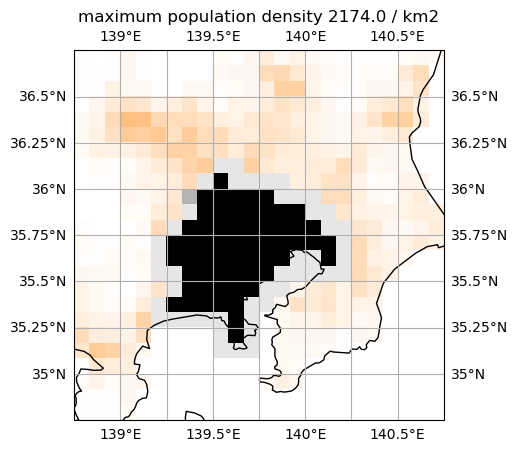

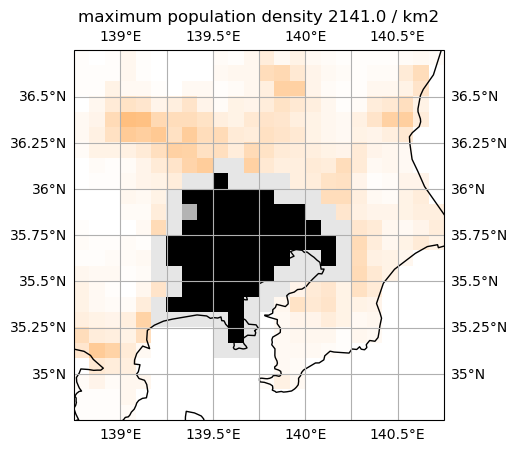

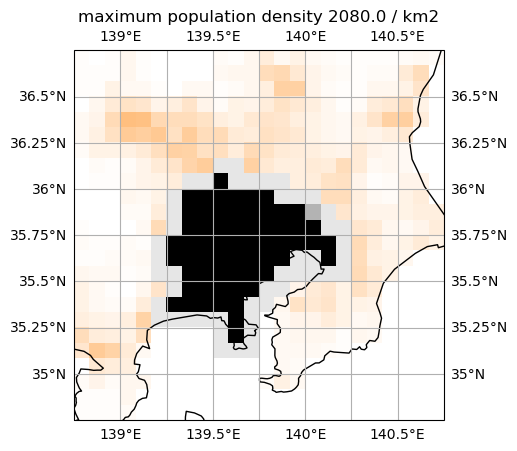

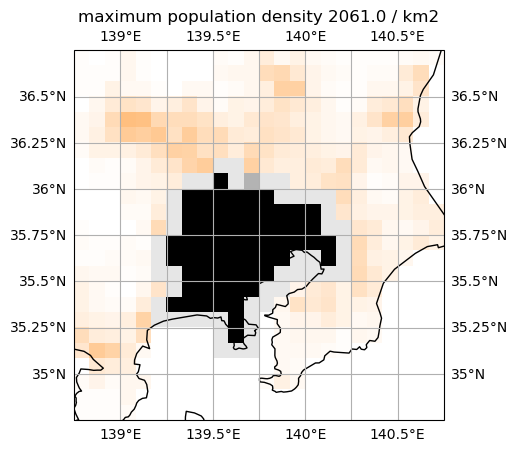

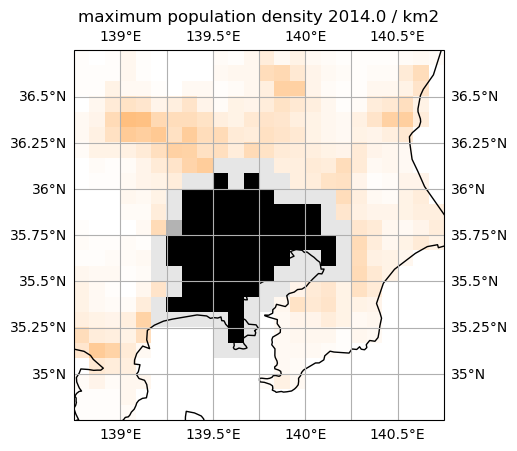

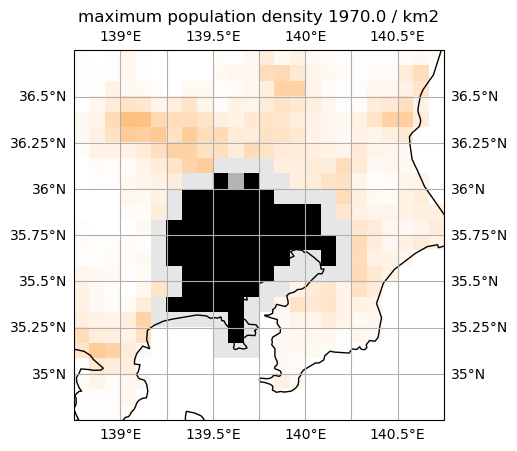

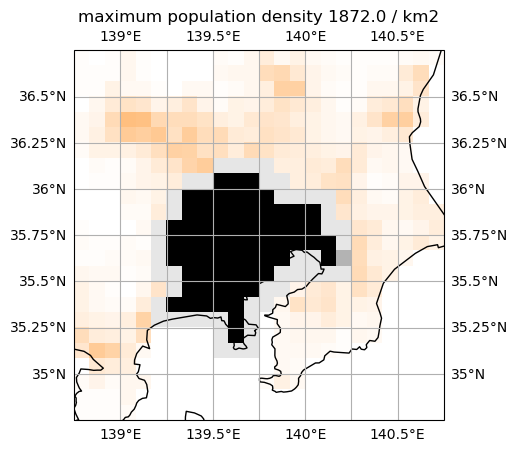

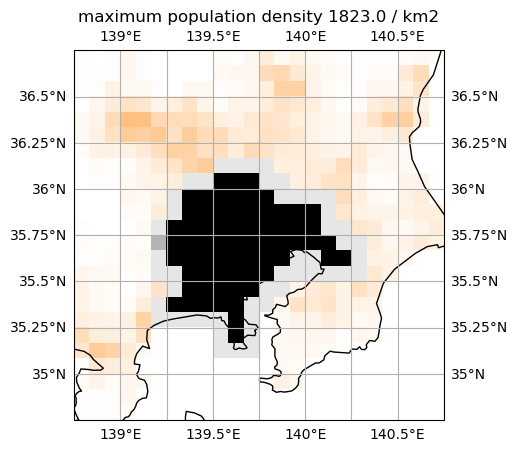

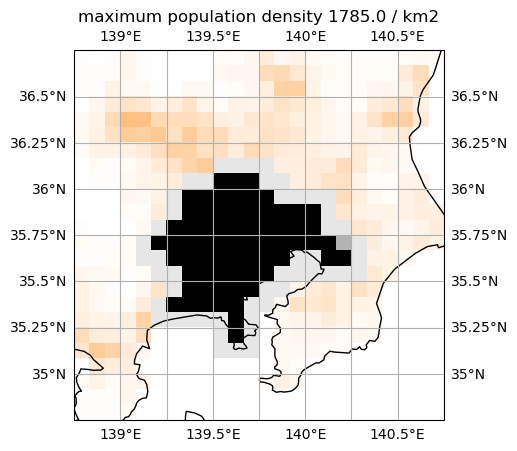

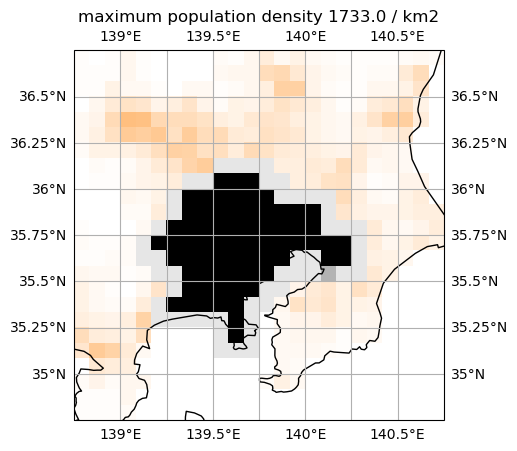

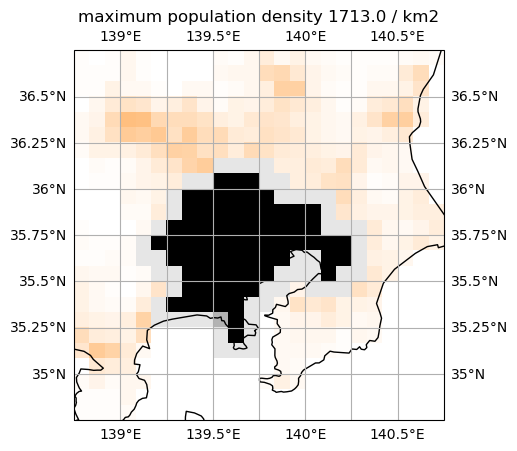

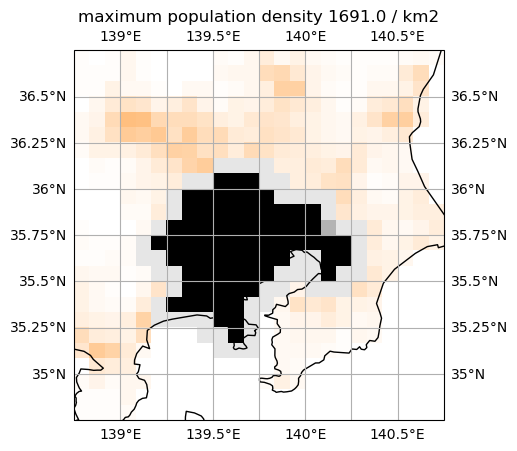

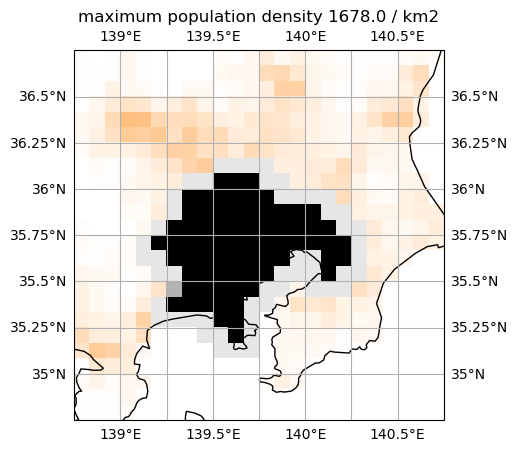

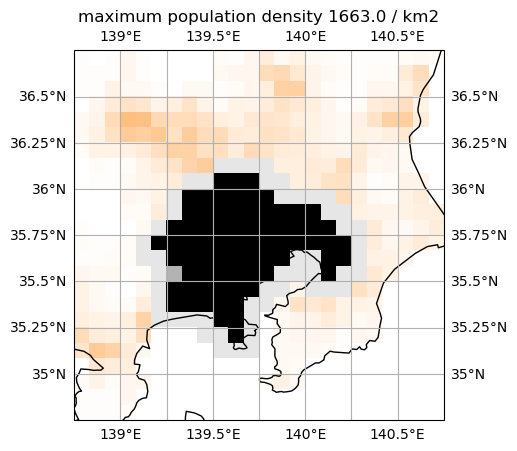

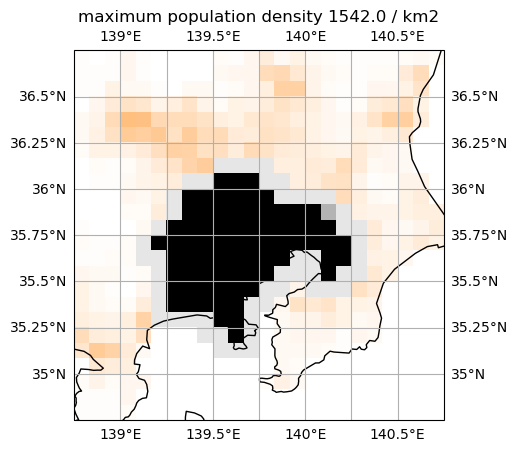

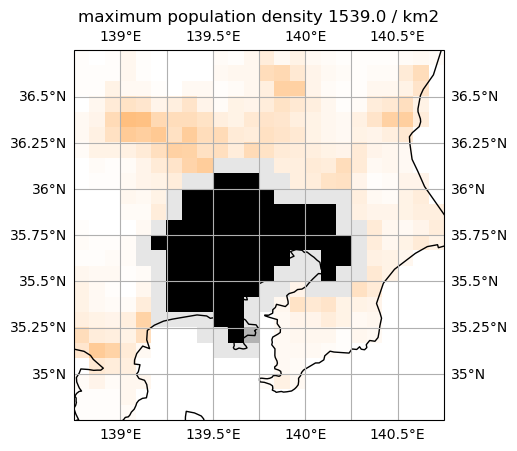

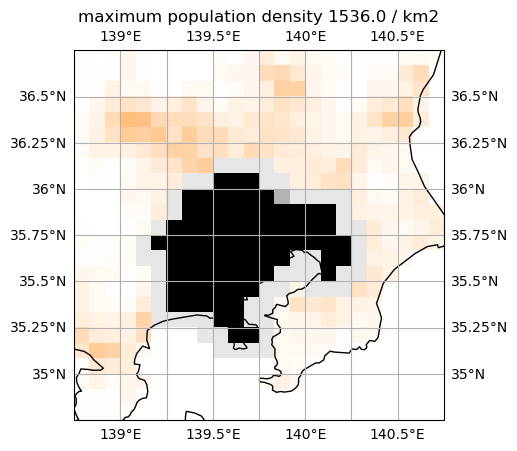

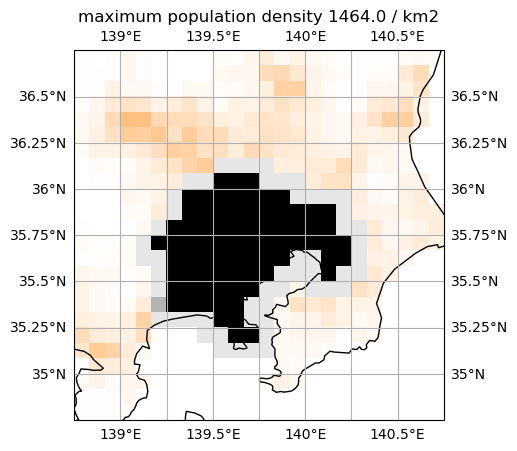

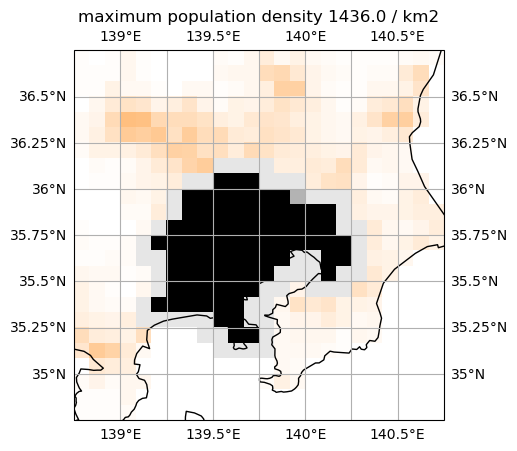

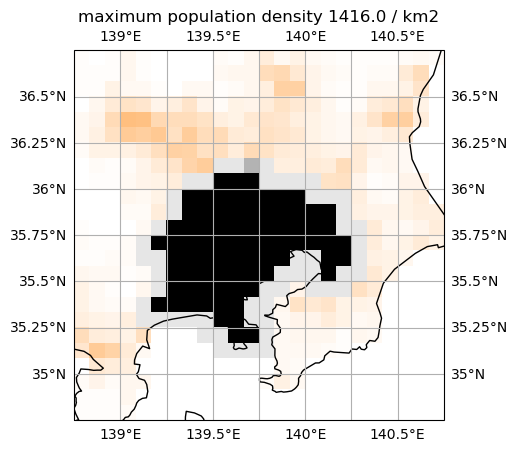

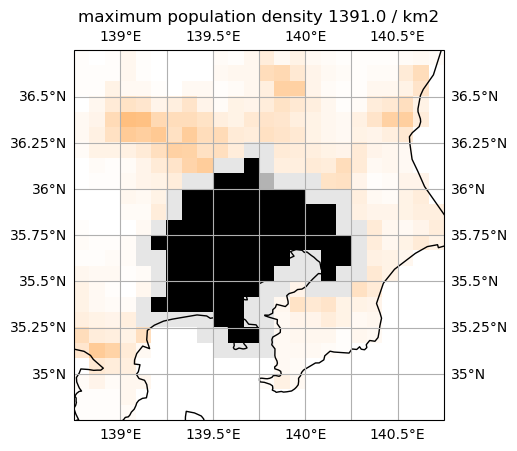

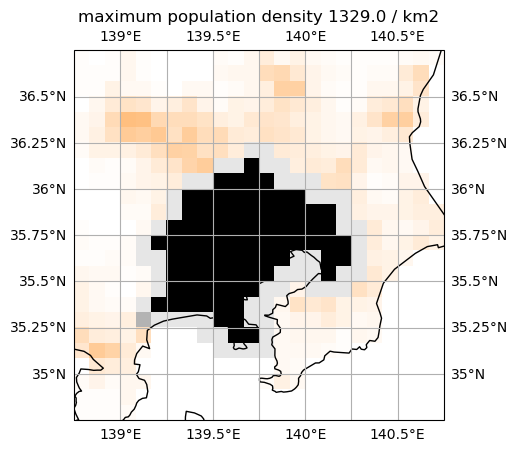

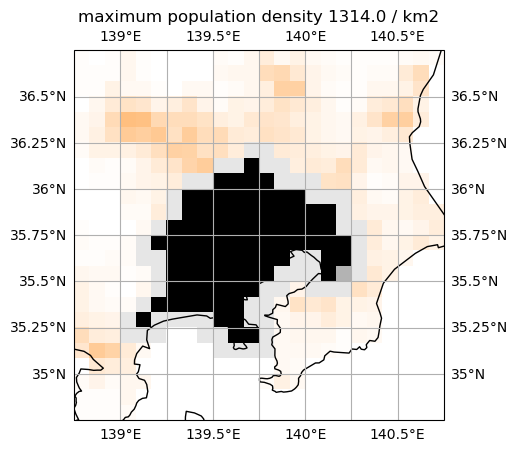

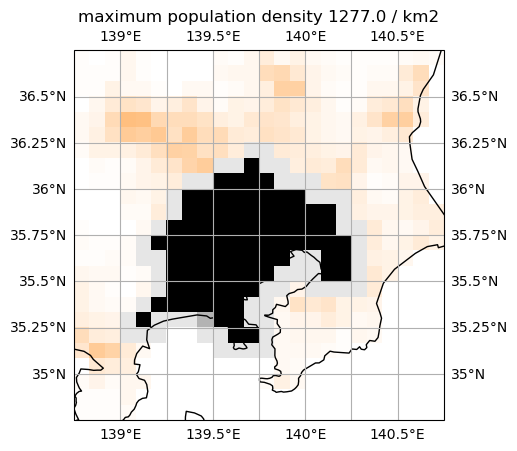

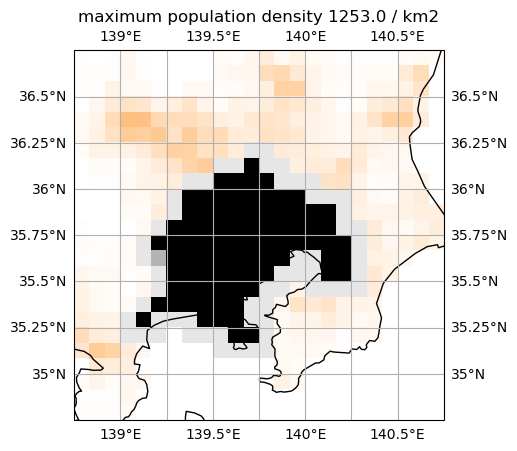

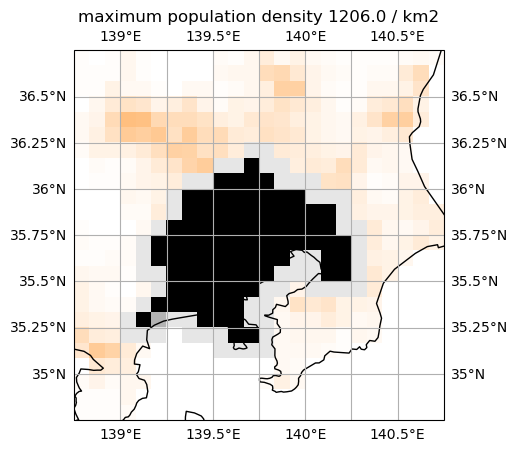

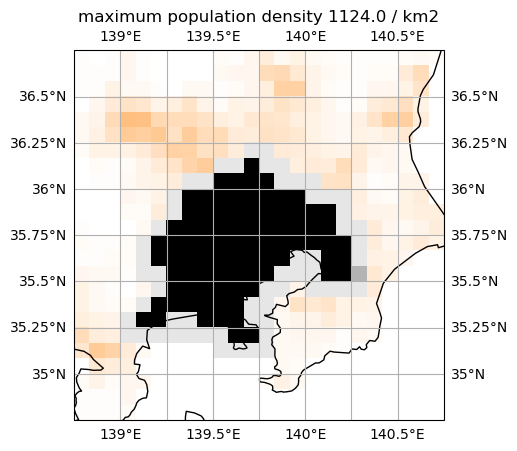

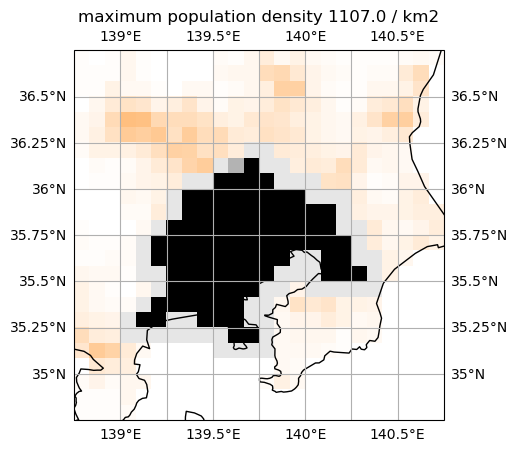

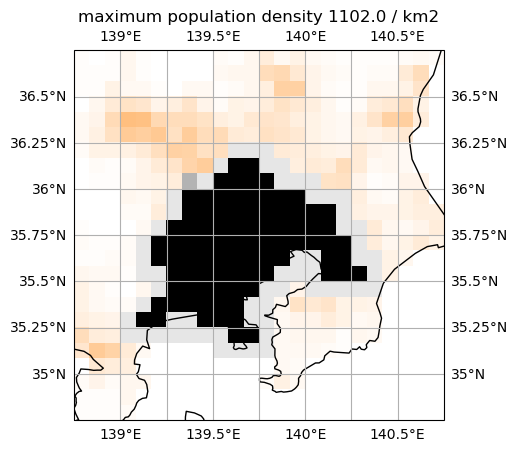

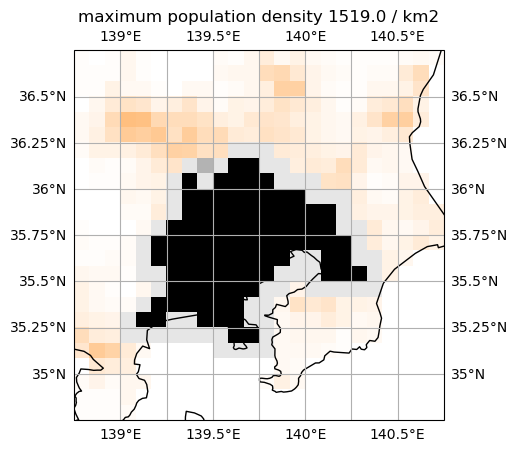

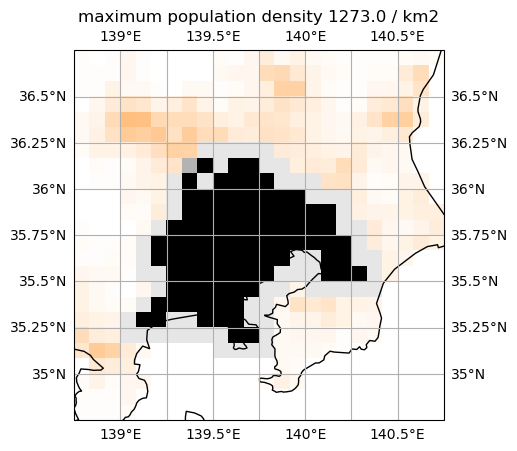

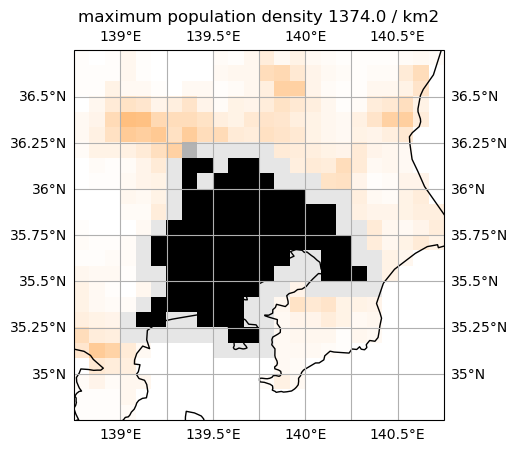

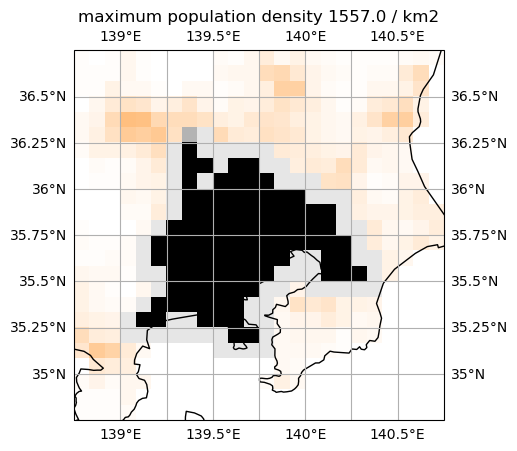

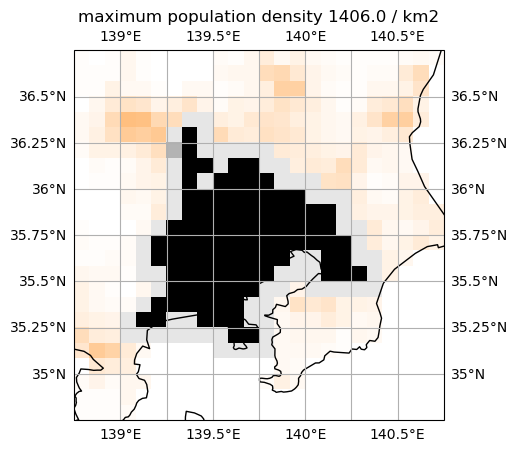

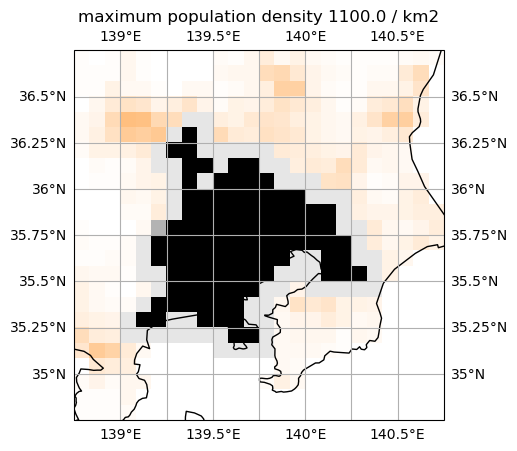

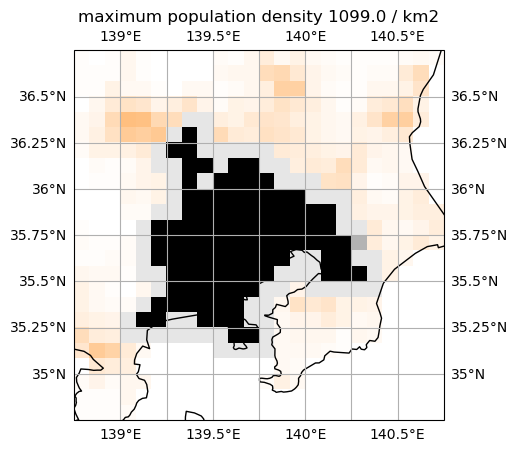

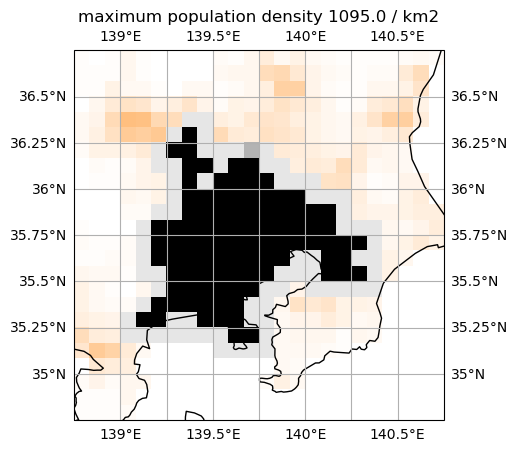

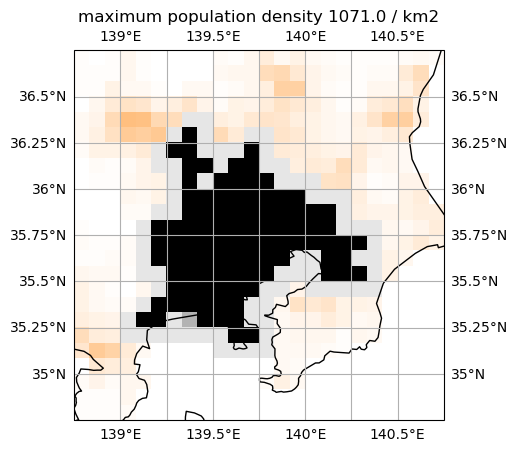

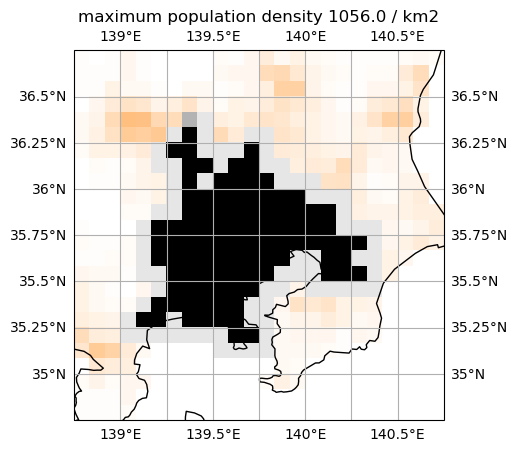

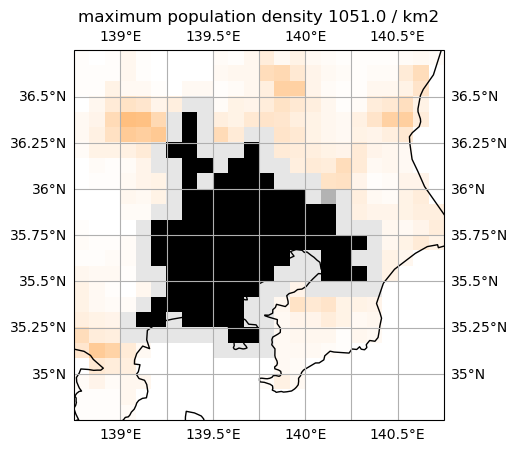

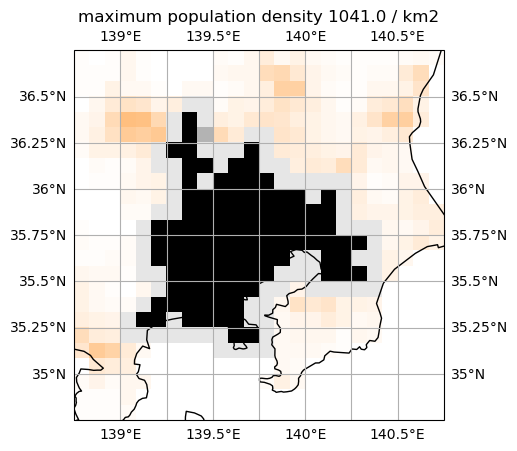

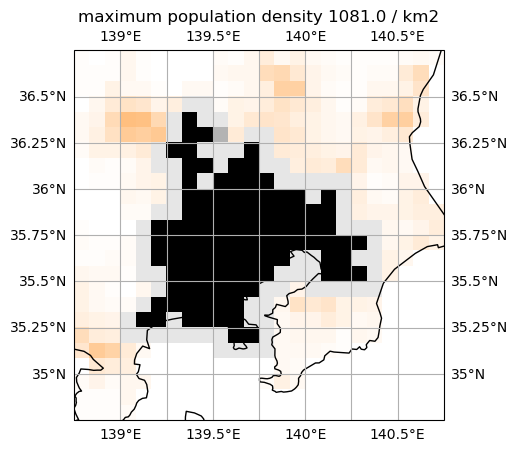

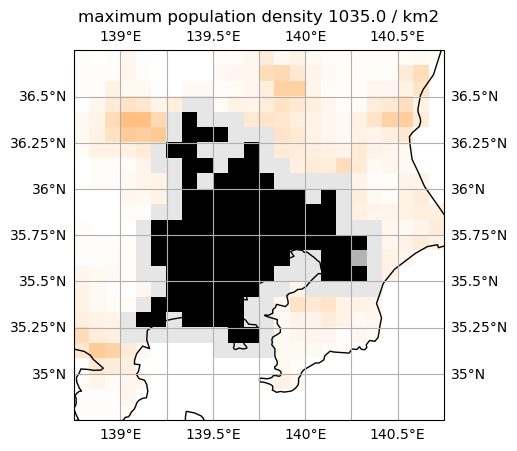

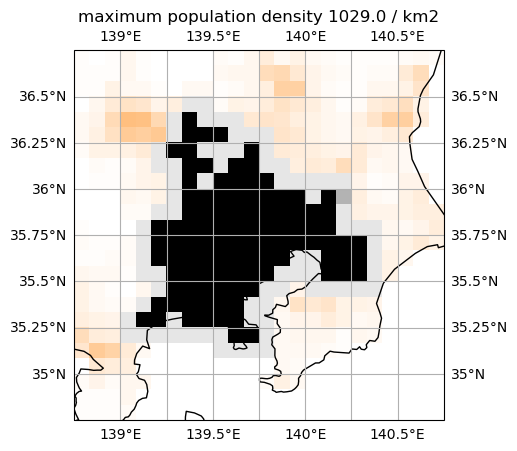

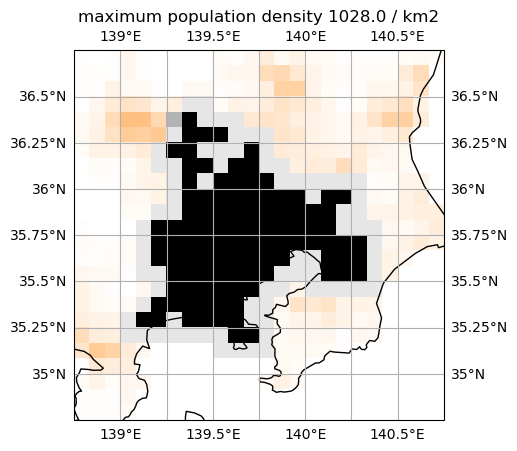

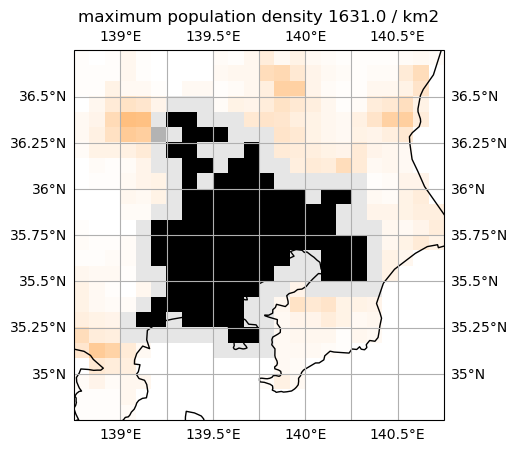

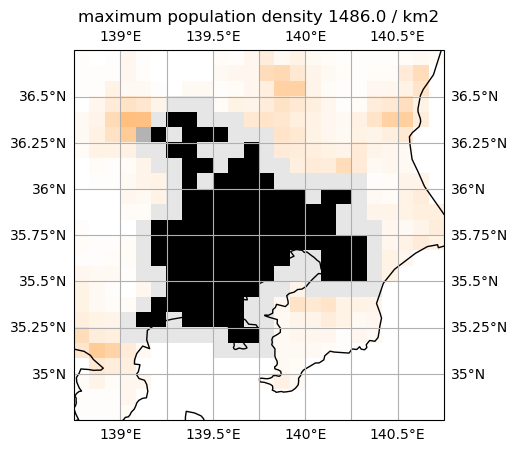

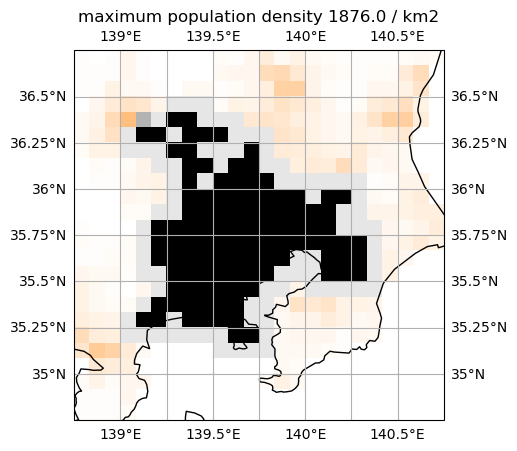

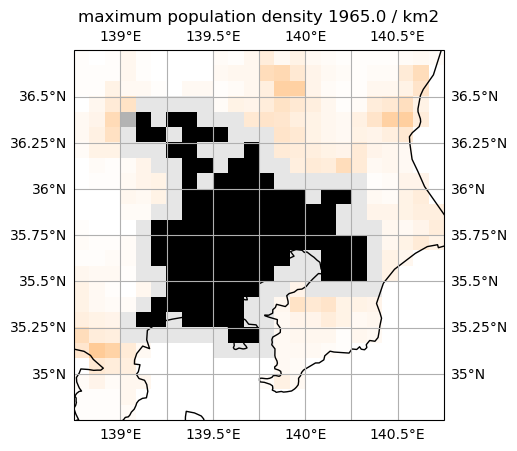

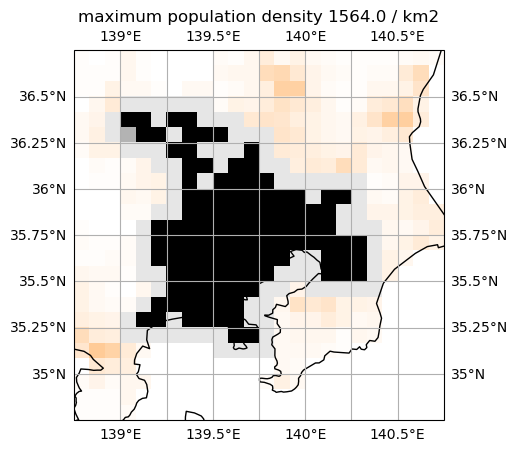

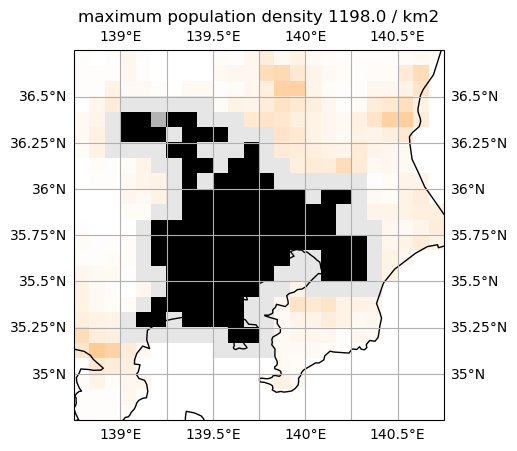

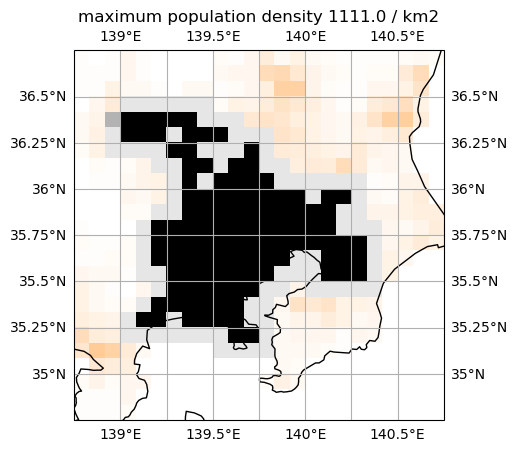

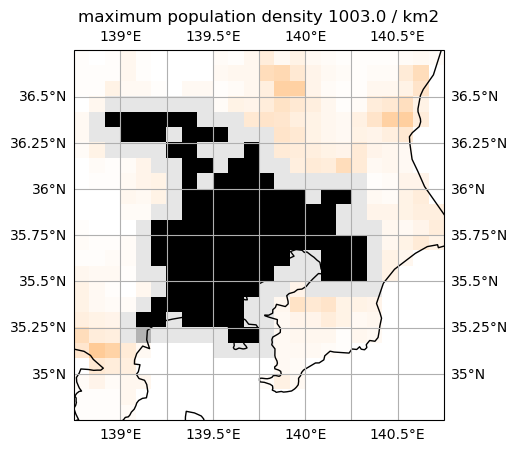

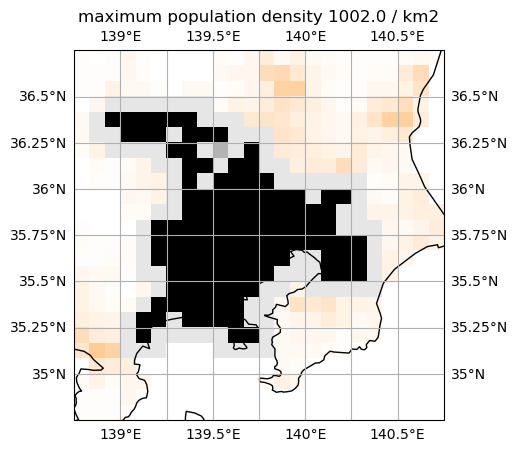

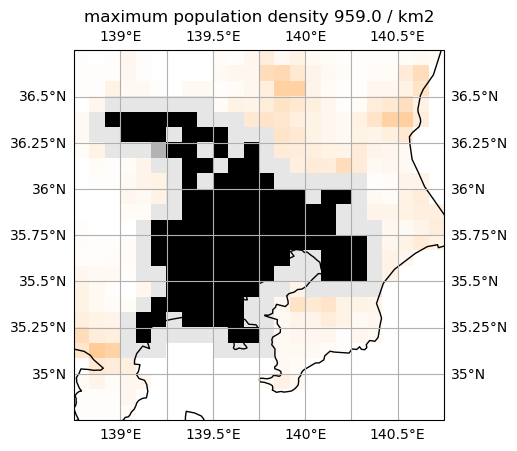

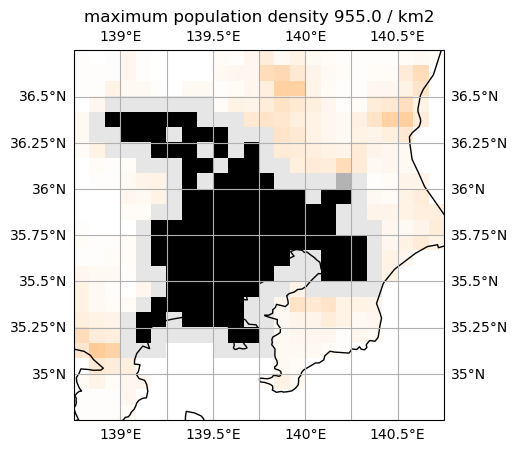

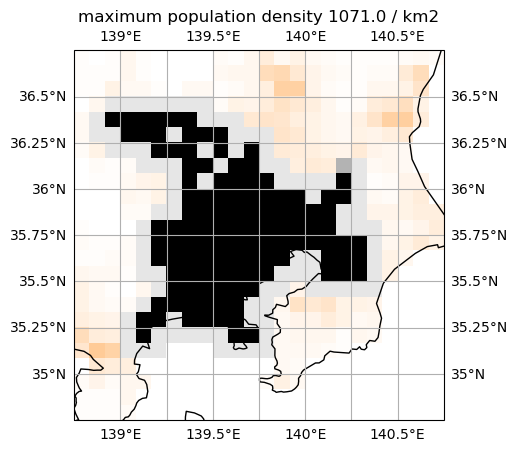

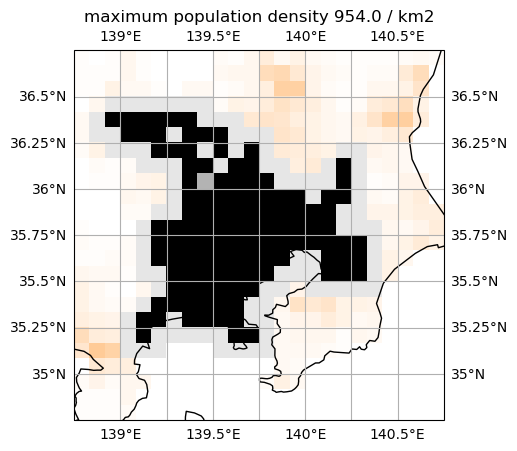

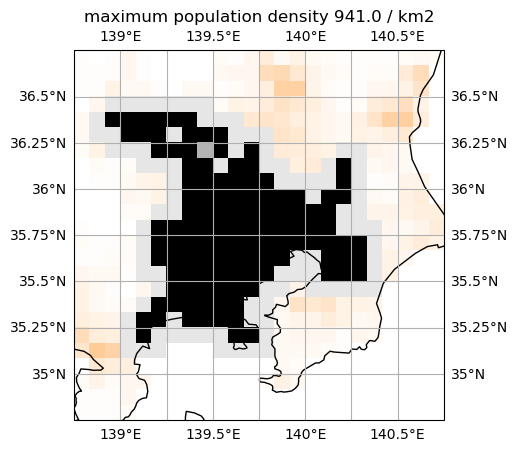

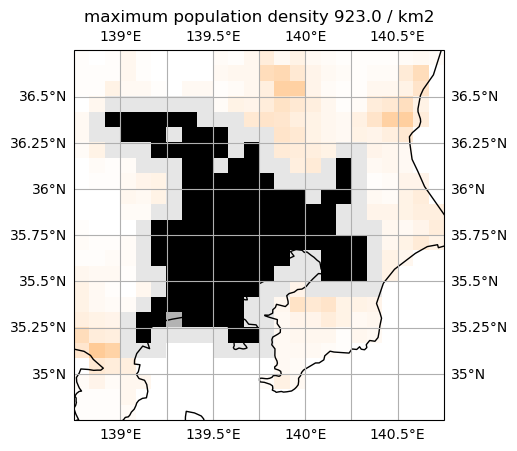

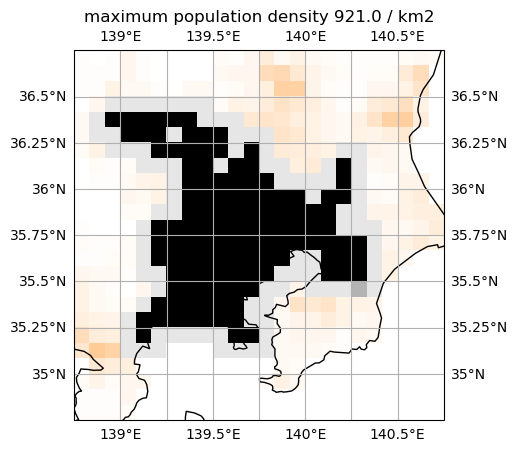

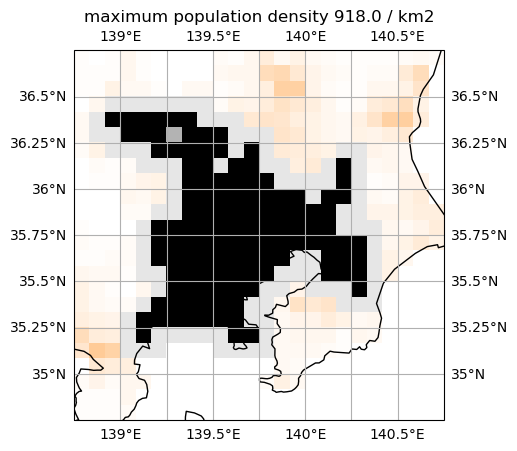

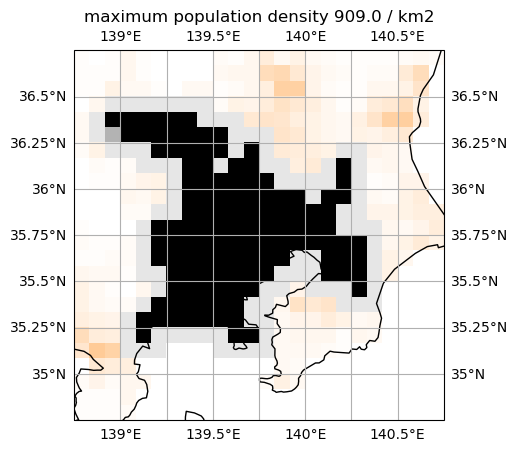

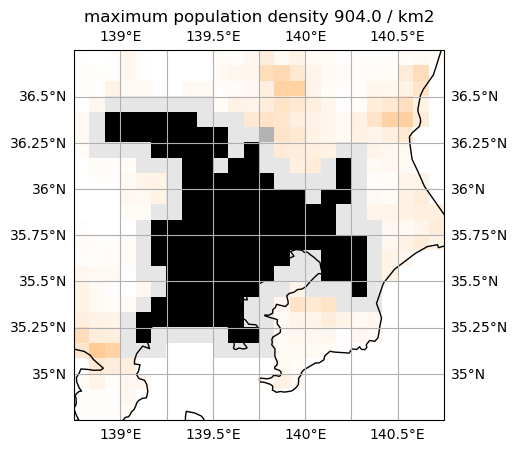

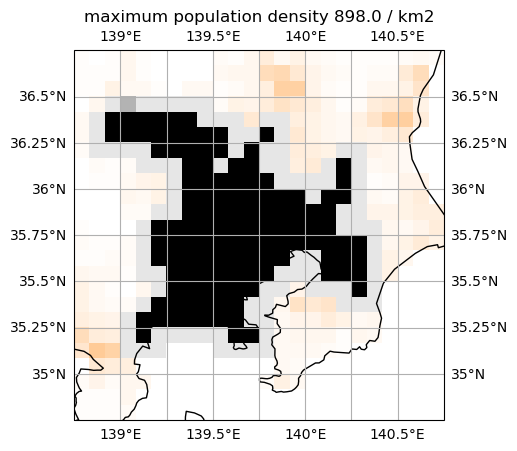

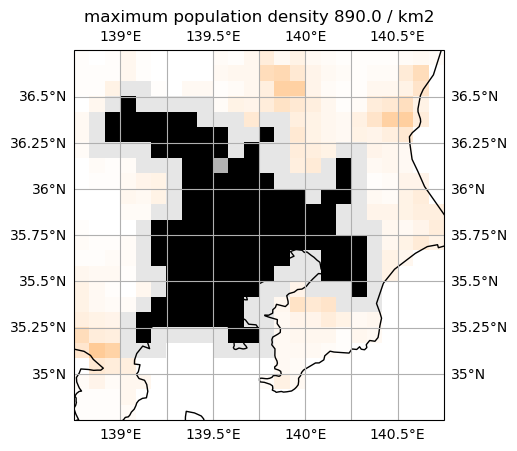

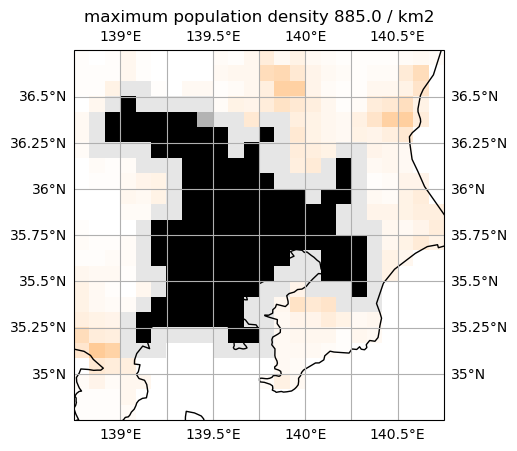

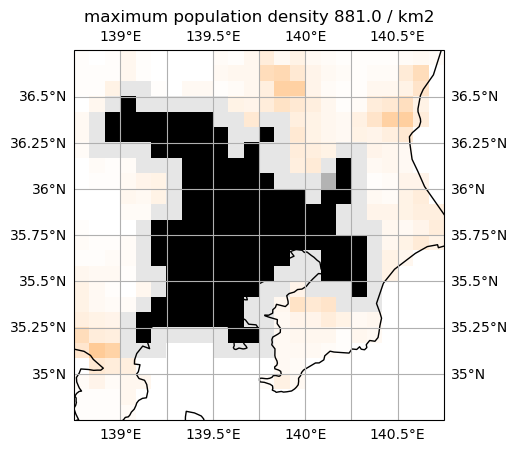

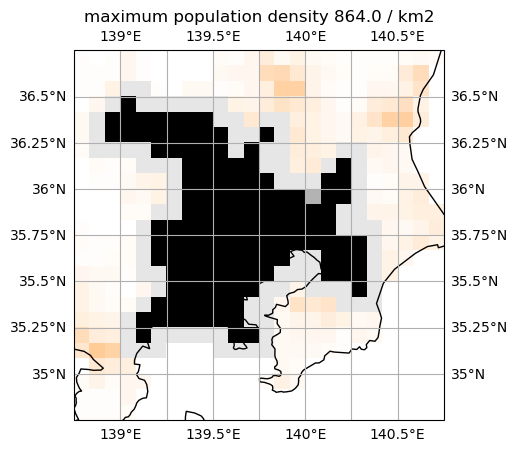

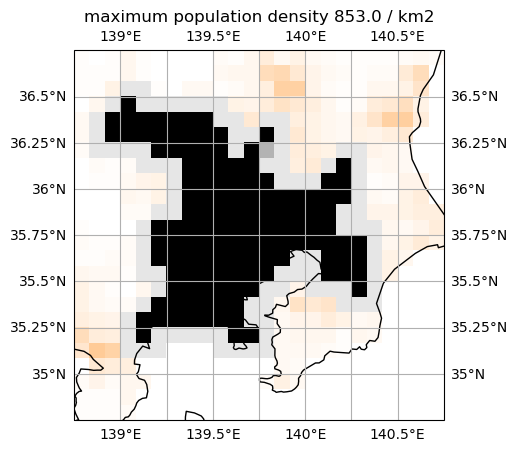

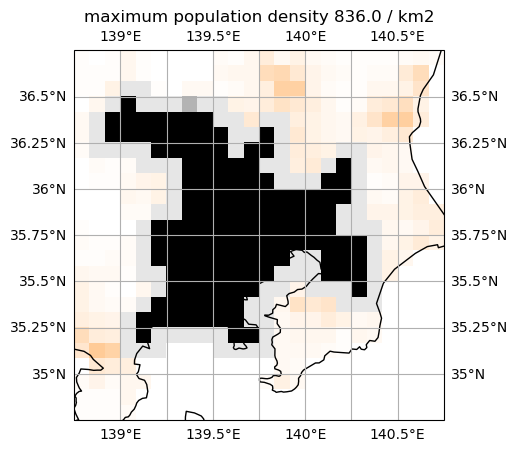

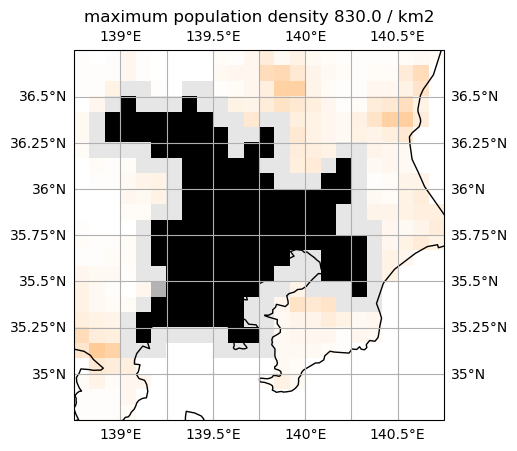

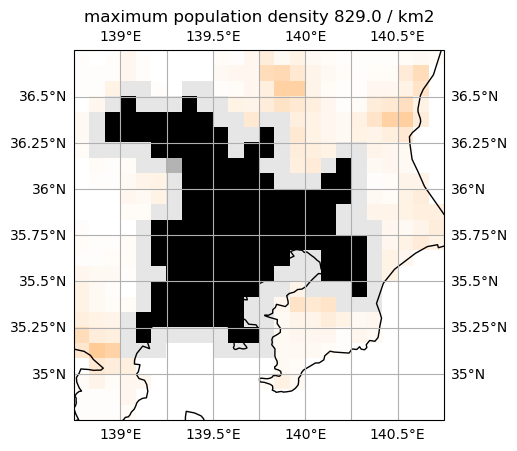

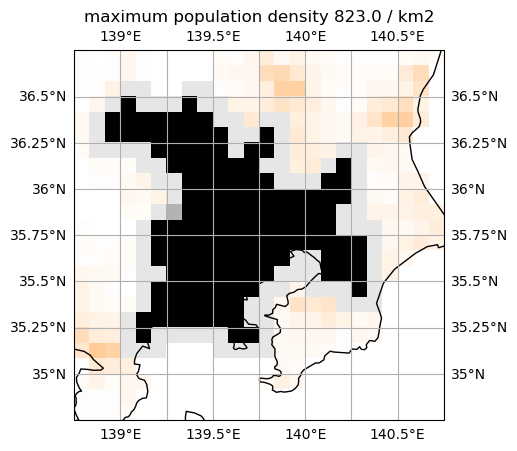

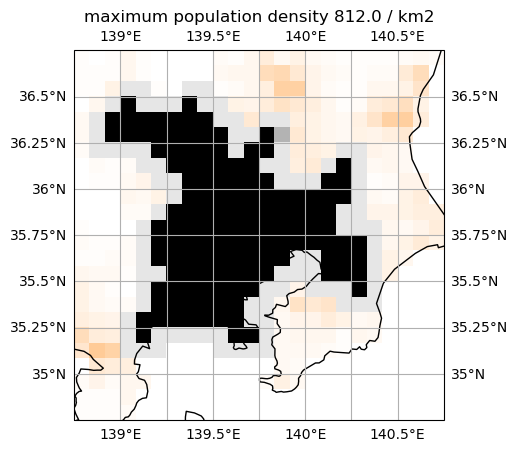

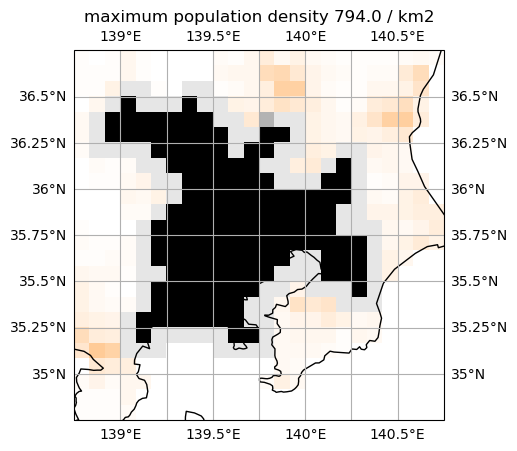

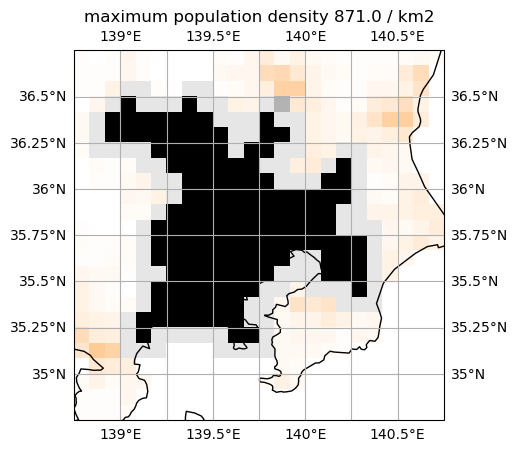

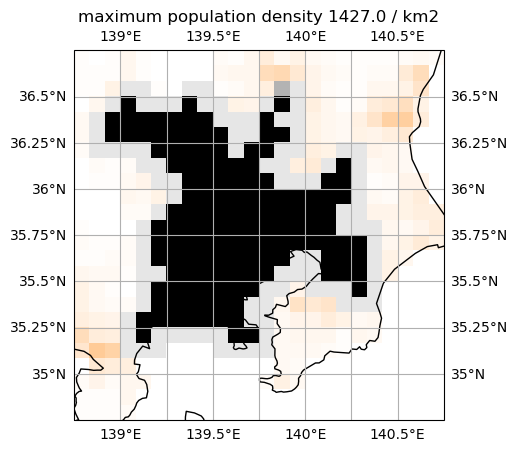

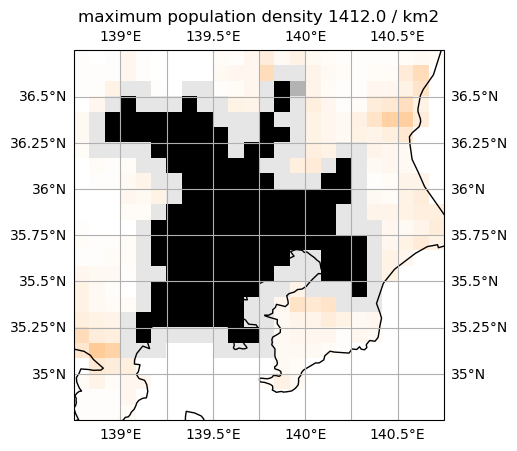

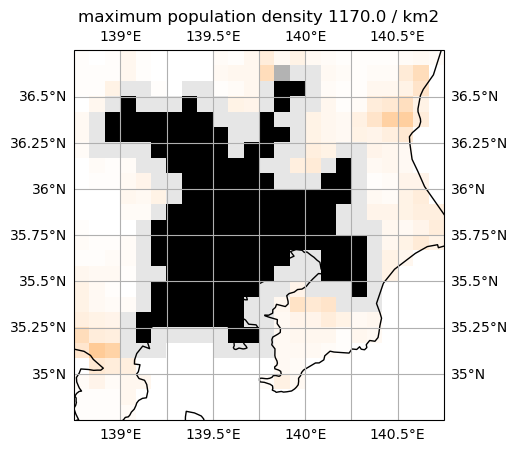

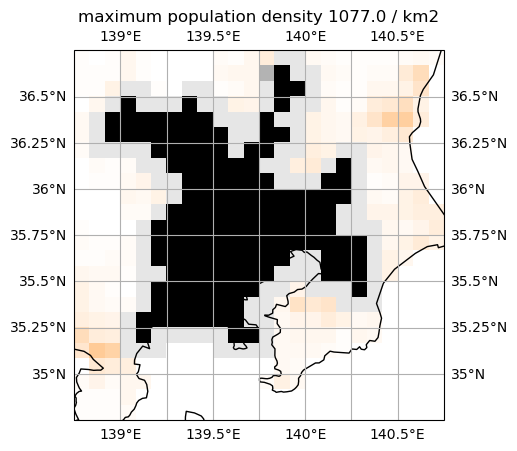

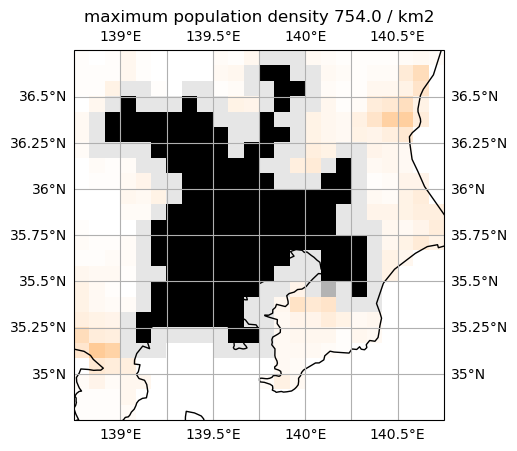

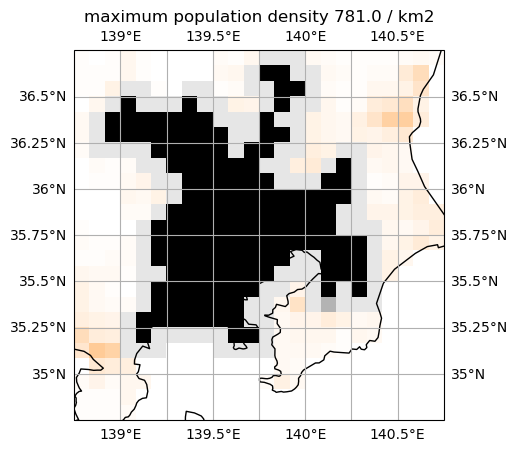

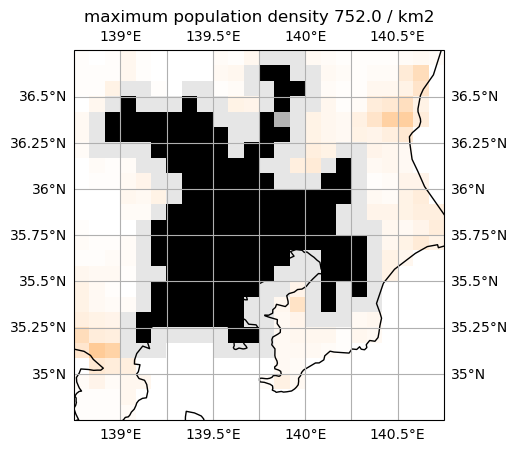

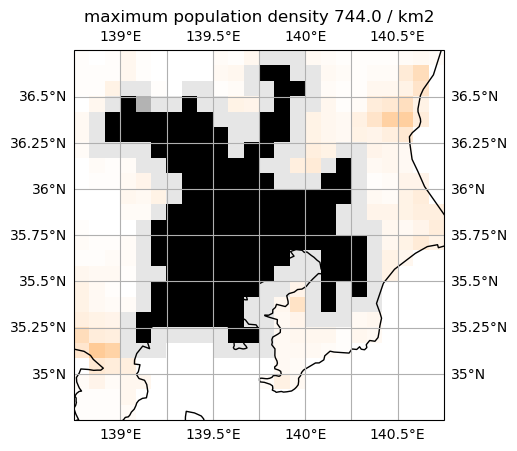

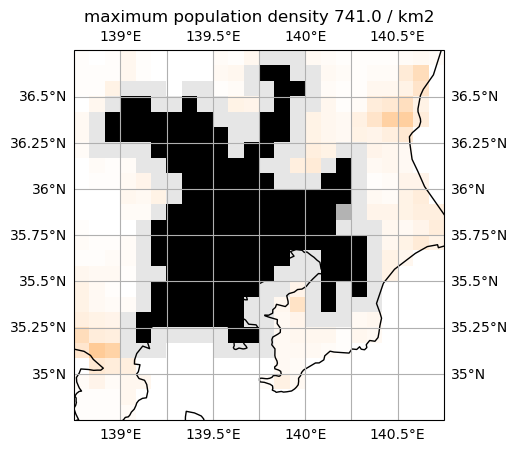

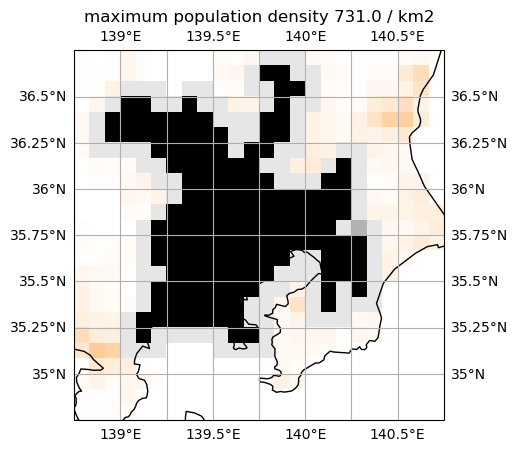

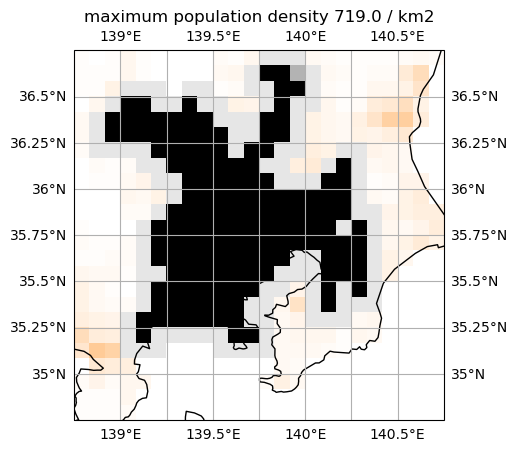

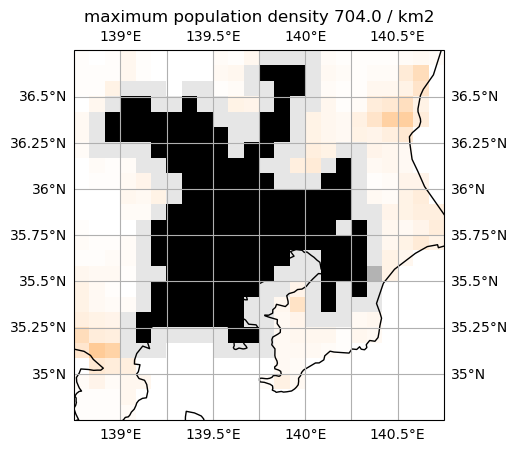

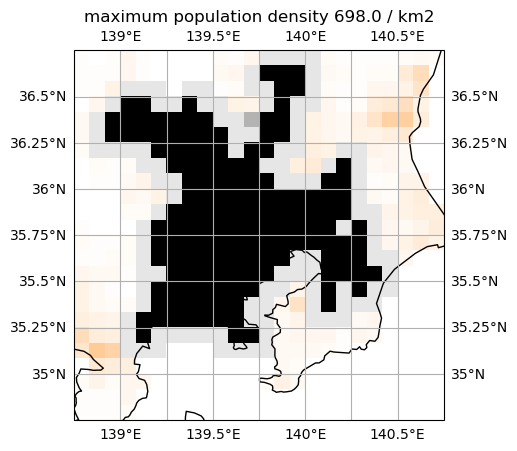

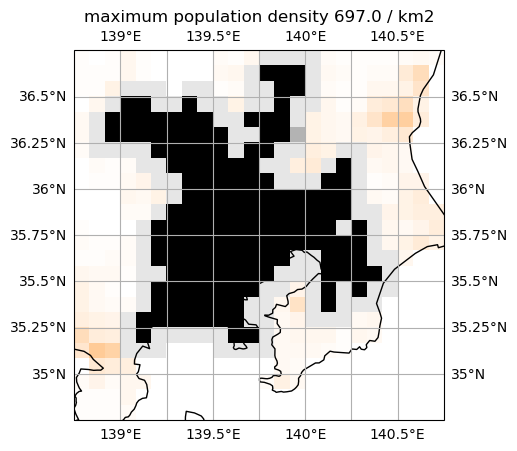

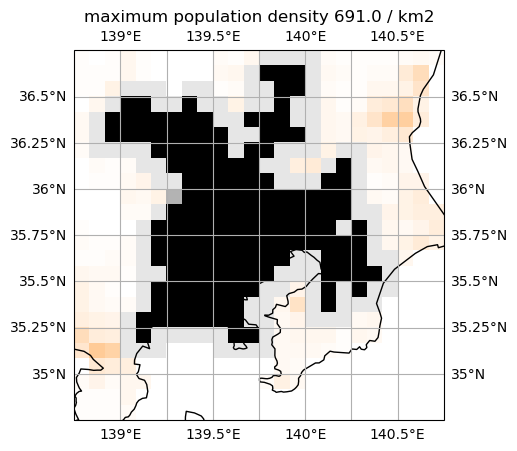

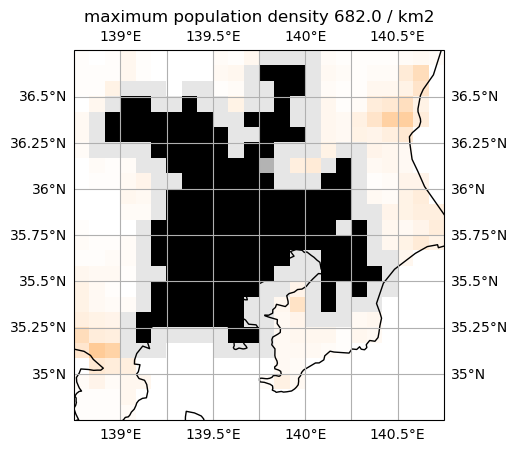

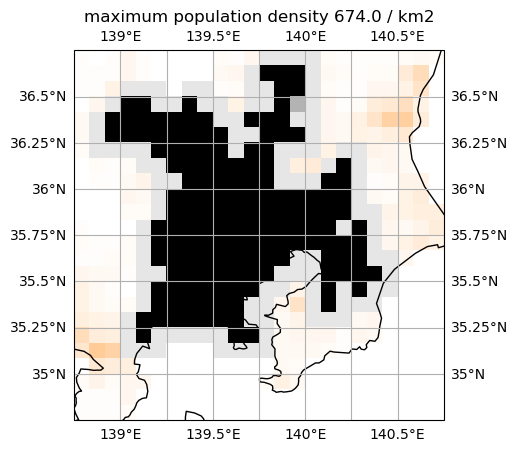

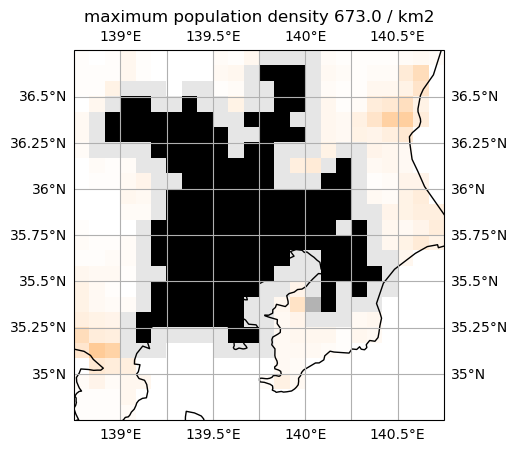

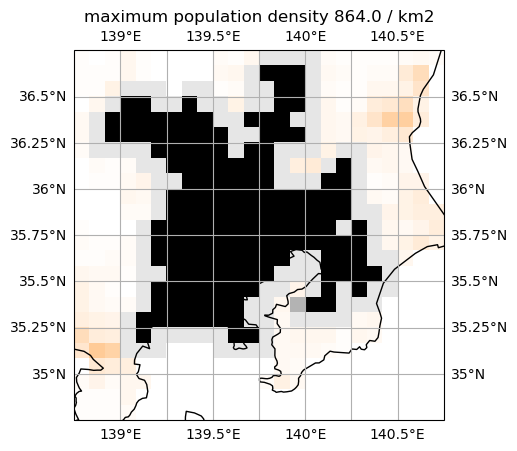

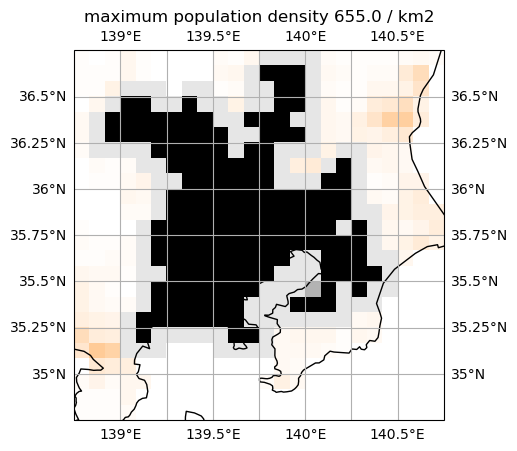

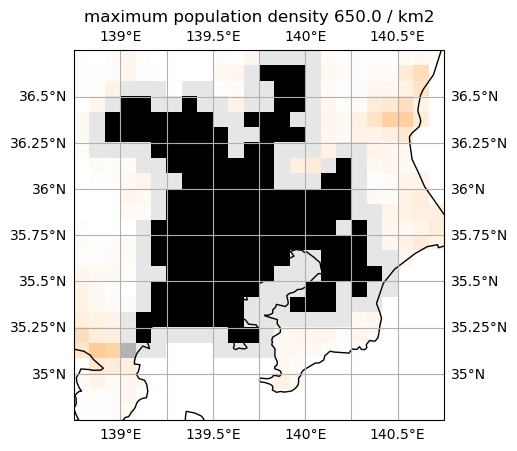

#########################################
explored_pop 34465068.0
true_pop 34450000
coverage 1.0004373875181423
city_mask 157.0
Tokyo
#########################################


In [118]:
# execute
index=1
explore_citymask(index)